In [1]:
import networkx as nx
import os
import glob
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pickle
import networkx as nx
import matplotlib as mlp
mlp.use("Qt5Agg")
import matplotlib.pyplot as plt
import community
import scipy
import bct

# Functions

### Function to threshold graphs

In [2]:
def threshold(G, corr_direction):
    ##Creates a copy of the graph
    H = G.copy()
    for stock1, stock2, weight in list(G.edges(data=True)):
        if corr_direction == "positive":
            if weight["weight"] <0:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0:
                H.remove_edge(stock1, stock2)
    return(H)

### Function to unpickle data

In [3]:
def onetoughjar(path2dic):
    with open(path2dic, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

### Function to create graphs of all the nodes

In [4]:
def grace_graph(graph, group,labels):
    G=graph
    positions = nx.circular_layout(G)
    size = 100
    title= "Modularity and edge weights \n of average %s graph"%(group)
    save="%s_graph.png"%(group)
    
    edges,weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    nodes, color = zip(*nx.get_node_attributes(G, 'modules').items()) #if your modules are named different change here
    # nodes, names = zip(*nx.get_node_attributes(graph, 'label').items()) #if your modules are named different change here
    
    #Figure size
    plt.figure(figsize=(80,50))

    #draws nodes
    color = np.array(color)
    n_color=len(list(set(color)))
    # nColormap=plt.cm.Set3 #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cM=color.max()
    cm=color.min()
    # get discrete colormap
    nColormap = plt.get_cmap('Set3', n_color)

    # scaling
    sz=np.array(size)
    scale=15000/sz.max()
    sza=sz*scale
    # print(sz.shape)

    y=nx.draw_networkx_nodes(G,positions,
                           node_color=color,
                           node_size=sza,
                           alpha=0.8,
                           cmap= nColormap,
                           vmin=cm ,vmax=cM)

    #Styling for labels
    if labels == "yes":
        nx.draw_networkx_labels(G, positions,
                                labels = label_dict,
                                font_size=50,
                                font_family='sans-serif',
                                fontweight = 'bold')
    else:
        nx.draw_networkx_labels(G, positions,
#                                 labels = label_dict,
                                font_size=50,
                                font_family='sans-serif',
                                fontweight = 'bold')
    #draw edges
    weights=np.array(weights)
    eColormap=plt.cm.gist_rainbow #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    # scaling
    wt=list(set(weights))
    wt=np.array(wt)
    wt2=-np.sort(-wt)
    wt0=wt2[1]

    escale=1/wt0
    esza=weights*escale
    E=list(set(esza))
    E2=-np.sort(-np.array(E))
    M=1
    m=0

    x=nx.draw_networkx_edges(G, positions,
                           edge_list=edges,
                           style='solid',
                           width = np.square(esza)*20,
                           edge_color = esza,
                           edge_cmap=eColormap,
                           edge_vmin=m,
                           edge_vmax=M)

    #COLORBAR STUFF
    node_bar=plt.colorbar(y, label='Module value')

    tick_locs = (np.arange(n_color) + 0.5)*(n_color-1)/n_color
    node_bar.set_ticks(tick_locs)

    # set tick labels (as before)
    node_bar.set_ticklabels(np.arange(n_color))


    sm = plt.cm.ScalarMappable(cmap=eColormap, norm=plt.Normalize(vmin = m, vmax=M))
    sm._A = []
    edge_bar=plt.colorbar(sm)

    for l in edge_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
    for l in node_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
        l.set_verticalalignment('center')

    node_bar.set_label('Modularity',fontsize = 50)
    edge_bar.set_label('Strength of edge weight',fontsize = 50)
    # Final plot stuff
    plt.axis('off')

    plt.title(title, fontsize = 100)
    basepath='/Users/gracer/Google Drive/HCP_graph/1200/images'

    plt.savefig(os.path.join(basepath,save), format="PNG")
    plt.show()
    return()

In [5]:
def module_fig(G, group, IC):
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #nodes, size = zip(*nx.get_node_attributes(G,'clustering').items())

    positions=nx.circular_layout(G)
    plt.figure(figsize=(80,50))
    ### NODES ####
    color = np.array(list(G.nodes))
    color = np.array(color)
    n_color=len(list(set(color)))
    nColormap = plt.get_cmap('Set3', n_color)

    y=nx.draw_networkx_nodes(G,positions,
                           node_color=color,
                           node_size=15000,
                           alpha=1.0,
                           cmap= nColormap,
                           vmin=0,vmax=n_color )

    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=100,
                            font_family='sans-serif', fontweight = 'bold')
    
    ### EDGES ####
    weights=np.array(weights)

    m=weights.min()
    M=weights.max()
    
    eColormap=plt.cm.gist_rainbow
    
    x=nx.draw_networkx_edges(G, positions, 
                             edge_list=edges,
                             style='solid', 
                             width = weights,
                             edge_color = weights, 
                             edge_vmin=m, 
                             edge_vmax=M, 
                             edge_cmap= eColormap)

    
    node_bar=plt.colorbar(y, label='Module value')
    
    tick_locs = (np.arange(n_color) + 0.5)*(n_color-1)/n_color
    node_bar.set_ticks(tick_locs)

    # set tick labels (as before)
    node_bar.set_ticklabels(np.arange(n_color))


    sm = plt.cm.ScalarMappable(cmap=eColormap, norm=plt.Normalize(vmin = m, vmax=M))
    sm._A = []
    edge_bar=plt.colorbar(sm)

    for l in edge_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
    for l in node_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
        l.set_verticalalignment('center')

    node_bar.set_label('Modularity',fontsize = 50)
    edge_bar.set_label('Strength of edge weight',fontsize = 50)
    
    plt.title("Module Connectivity Weights %s %s"%(group, IC), fontsize = 100)
    plt.axis('off')
    basepath='/Users/gracer/Google Drive/HCP_graph/1200/images'
#     plt.savefig(os.path.join(basepath,"modularity_%s.png"%(Type)), format="PNG")
    # plt.show()

### Function to create communities

In [6]:
def com_create(mu):
    partition = community.best_partition(mu)
    vals = list(partition.values())
    nx.set_node_attributes(mu, partition, 'modules')
    return((partition,vals, mu))

### Function to generate p values

In [7]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

### Function to visualize the module graphs

In [8]:
def inmod_graph(graph, group):
#     graph=threshold(graph,dirp,minp)
    e,w = zip(*nx.get_edge_attributes(graph, 'weight').items())
    positions = nx.circular_layout(graph)
    size = 100
    title= "Modularity and edge weights \n of average %s graph"%(group)
    save="%s_graph.png"%(group)
    
    edges,weights = zip(*nx.get_edge_attributes(graph, 'weight').items())

    nodes, color = zip(*nx.get_node_attributes(graph, 'modules').items()) #if your modules are named different change here
    # nodes, names = zip(*nx.get_node_attributes(graph, 'label').items()) #if your modules are named different change here
    g=graph
    #Figure size
    plt.figure(figsize=(80,50))

    #draws nodes
    color = np.array(color)
    n_color=len(list(set(color)))
    # nColormap=plt.cm.Set3 #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cM=color.max()
    cm=color.min()
    # get discrete colormap
    nColormap = plt.get_cmap('Set3', n_color)

    # scaling
    sz=np.array(size)
    scale=15000/sz.max()
    sza=sz*scale
    # print(sz.shape)

    y=nx.draw_networkx_nodes(g,positions,
                           node_color=color,
                           node_size=sza,
                           alpha=0.8,
                           cmap= nColormap,
                           vmin=cm ,vmax=cM)

    #Styling for labels
    nx.draw_networkx_labels(g, positions,
                            # labels = label_dict,
                            font_size=50,
                            font_family='sans-serif',
                            fontweight = 'bold')

    #draw edges
    weights=np.array(weights)
    eColormap=plt.cm.gist_rainbow #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#     # scaling
#     wt=list(set(weights))
#     wt=np.array(wt)
#     wt2=-np.sort(-wt)
#     wt0=wt2[1]

#     escale=1/wt0
#     esza=weights*escale
#     E=list(set(esza))
#     E2=-np.sort(-np.array(E))
    M=1
    m=-1

    x=nx.draw_networkx_edges(g, positions,
                           edge_list=edges,
                           style='solid',
                           width = np.square(weights)*100,
                           edge_color = weights,
                           edge_cmap=eColormap,
                           edge_vmin=m,
                           edge_vmax=M)

    #COLORBAR STUFF
    node_bar=plt.colorbar(y, label='Module value')

    tick_locs = (np.arange(n_color) + 0.5)*(n_color-1)/n_color
    node_bar.set_ticks(tick_locs)

    # set tick labels (as before)
    node_bar.set_ticklabels(np.arange(n_color))


    sm = plt.cm.ScalarMappable(cmap=eColormap, norm=plt.Normalize(vmin = m, vmax=M))
    sm._A = []
    edge_bar=plt.colorbar(sm)

    for l in edge_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
    for l in node_bar.ax.yaxis.get_ticklabels():
        l.set_size(50)
        l.set_verticalalignment('center')

    node_bar.set_label('Modularity',fontsize = 50)
    edge_bar.set_label('Strength of edge weight',fontsize = 50)
    # Final plot stuff
    plt.axis('off')

    plt.title(title, fontsize = 100)
    basepath='/Users/gracer/Google Drive/HCP_graph/1200/images'

    plt.savefig(os.path.join(basepath,save), format="PNG")
    plt.show()
    return()

### Function to look at the p values quickly

In [9]:
def skimP(mat):
    mask = np.zeros_like(mat)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(14, 10))
        ax = sns.heatmap(mat, mask=mask,annot=True, center=0.05,square=True, cmap='gist_ncar')
#         ax.set_title(name)

### Function to generate graph and metrics

In [10]:
# <ipython-input-134-6c1090e2f207> in module_degree_zscore(W, ci, flag)
#      33     for i in range(1, int(np.max(ci) + 1)):
#      34         Koi = np.sum(W[np.ix_(ci == i, ci == i)], axis=1)
# ---> 35         Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)
#      36 
#      37     Z[np.where(np.isnan(Z))] = 0

# ValueError: shape mismatch: value array of shape (10,1) could not be broadcast to indexing result of shape (10,)



In [11]:
def module_degree_zscore(W, ci, flag=0):
    '''
    The within-module degree z-score is a within-module version of degree
    centrality.
    Parameters
    ----------
    W : NxN np.narray
        binary/weighted directed/undirected connection matrix
    ci : Nx1 np.array_like
        community affiliation vector
    flag : int
        Graph type. 0: undirected graph (default)
                    1: directed graph in degree
                    2: directed graph out degree
                    3: directed graph in and out degree
    Returns
    -------
    Z : Nx1 np.ndarray
        within-module degree Z-score
    '''
    _, ci = np.unique(ci, return_inverse=True)
    ci = ci + 1

    if flag == 2:
        W = W.copy()
        W = W.T
    elif flag == 3:
        W = W.copy()
        W = W + W.T

    n = len(W)
    print("this is n %i"%n)
    Z = np.zeros((n,1))  # number of vertices
    for i in range(1, int(np.max(ci) + 1)):
        Koi = np.sum(W[np.ix_(ci == i, ci == i)], axis=1)
        Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)

    Z[np.where(np.isnan(Z))] = 0
    return Z


In [12]:
def participation_coef(W, ci, degree='undirected'):
    '''
    Participation coefficient is a measure of diversity of intermodular
    connections of individual nodes.
    Parameters
    ----------
    W : NxN np.ndarray
        binary/weighted directed/undirected connection matrix
    ci : Nx1 np.ndarray
        community affiliation vector
    degree : str
        Flag to describe nature of graph 'undirected': For undirected graphs
                                         'in': Uses the in-degree
                                         'out': Uses the out-degree
    Returns
    -------
    P : Nx1 np.ndarray
        participation coefficient
    '''
    if degree == 'in':
        W = W.T

    _, ci = np.unique(ci, return_inverse=True)
    ci = ci + 1

    n = len(W)  # number of vertices
    Ko = np.sum(W, axis=1)  # (out) degree
    Gc = np.dot((W != 0), np.diag(ci))  # neighbor community affiliation
    Kc2 = np.zeros((n,))  # community-specific neighbors

    for i in range(1, int(np.max(ci)) + 1):
        Kc2 = Kc2 + np.square(np.sum(W * (Gc == i), axis=1))
        print("this is Kc2")
        print(Kc2)
    imd=Kc2 / np.square(Ko)
    print(imd)
    P = np.ones((n,)) - imd
    print(P)
    # P=0 if for nodes with no (out) neighbors
    P[np.where(np.logical_not(Ko))] = 0

    return P


In [13]:
def subgraph(value, group):
    G=value['graphs']
    mod=G.nodes(data=True)[group]['modules']
    print(mod)
    interest=[k for k,v in nx.get_node_attributes(G, 'modules').items() if v == mod]
    print(interest)
    X=nx.subgraph(G, interest)

In [14]:
def mu_make_graphs(key, values, direction):
    ########################################
    cor_matrix = np.asmatrix(values)
    G = nx.from_numpy_matrix(cor_matrix)
    ########################################
    tG = threshold(G, direction)
    if len(list(tG.edges(data=True))) > 0:
        if direction == 'negative':
            print('start negative')
            edges,weights = zip(*nx.get_edge_attributes(tG,'weight').items())
            wts=tuple(abs(np.array(weights)))
            total=[]
            for x in enumerate(edges):
                y={'weight':wts[x[0]]}
                total.append(x[1]+(y,))
            tG.add_edges_from(total)

        ########################################
        (partition,vals,graph)=com_create(tG)
        nx.set_node_attributes(tG, partition, 'modules')
        ########################################
        x=abs(cor_matrix)
        mu=x.mean()
        ########################################
#         PC = participation_coef(nx.to_numpy_matrix(tG), vals, 'undirected')
        ########################################
        zDegree=nx.module_degree_zscore(nx.to_numpy_matrix(tG), vals, flag=0)
        ########################################
        clustering = nx.clustering(tG, weight=True)
        ########################################
        centrality = nx.betweenness_centrality(tG, weight=True)
        ########################################
        nx.set_node_attributes(tG, centrality, 'centrality')
        nx.set_node_attributes(tG, clustering, 'clustering')
        nx.set_node_attributes(tG, partition, 'modules')
#         PCd = {el:PC[el].mean() for el in range(len(PC))}
#         nx.set_node_attributes(tG, PCd, 'PC')
        zDd = {el:zDegree[el][0] for el in range(len(zDegree))}
        nx.set_node_attributes(tG, zDd, 'zDegree')
        stocks = values.index.values
        tG = nx.relabel_nodes(tG,lambda x: stocks[x])
        ########################################
        return({'mean_FC':mu, 'graphs':tG, 'clustering_coeff':clustering, 'btn_centrality':centrality,  'modules':{'partition':partition,
    'values':vals,'graph':graph}, 'zDegree':zDegree})
    else:
        print('this is empty')
    

## Base dictionary structure

In [15]:
base_dict={'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }

## Load in appropriate files
1. Header = These are the ICs from the 15 dimenstion
2. labels = These are labels from the glasser and gordon merged brains (allowing for cortex and subcortex)
3. covars = These are the values of BMI, age at onset of menses, race, age, and head motion. The same file was used in FSLNETS

In [ ]:
header=['IC1','IC2','IC3','IC4','IC5','IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13','IC14','IC15']

In [85]:
labels = pd.read_csv('/Users/gracer/Google Drive/HCP_graph/1200/brains/lables_glasser.csv', sep=',')

In [113]:
labels.iloc[202]

area    L_V2_ROI
Name: 202, dtype: object

In [ ]:
c=['BMI','AoM','int','race','age','motion']
for x in c:
    labels.loc[x] = [x]

In [ ]:
label_dict=labels.to_dict('index')

In [ ]:
covars=pd.read_csv('/Users/gracer/Google Drive/HCP_graph/1200/datasets/subs510.csv', sep=',', header=None)

In [ ]:
covars.columns=['idx','subject','group','BMI','AoM','int','race','age','motion']

In [ ]:
covars.drop_duplicates(subset='subject', keep="last", inplace=True)

In [ ]:
covars.shape

In [ ]:
covars['subject']=covars['subject'].astype('int64')

In [ ]:
high_low=pd.read_csv('/Users/gracer/Google Drive/HCP_graph/1200/datasets/post_hoc.csv', sep=',')

In [ ]:
hl=high_low[['Subject','AoM']]
hl=hl.dropna()
hl.columns = ["subject", "high_low"]

### Load in all timeseries data from each participant into data_dict. 
These are the netmat2 files. They are zscores per TR

In [ ]:
raw_dict={'late':hl.loc[hl['high_low']=='late'],'early': hl.loc[hl['high_low'] == 'early']}
data_dict={'late':{},'early':{}}
for key, df in raw_dict.items():
    print(key)
    for sub in df['subject']:
        path=os.path.join(
            '/Users/gracer/Downloads/HCP_S1200_PTNmaps_d15_25_50_100/3T_HCP1200_MSMAll_d15_ts2_Z/puberty/%i.txt'%sub)
        data_dict[key][sub]=pd.read_csv(path,sep='\t',names=header)

In [ ]:
len(list(data_dict['late'].keys()))+len(list(data_dict['early'].keys()))

Check that you have 212 subjects/files

## Subset the ICs of interest
Don't need all the ICs. Just the ones already associated with BMI and puberty. This allows us to look at the relationships within IC.

In [ ]:
interest={'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }
for t, dt in interest.items():
    print(t)
    for x,y in dt.items():
        print(x)
        for k,v in y.items():
            print(k)
            for key, value in data_dict[t].items():
                v[key]=value[k]    

## Create datatables with the rows as subjects and columns as parcels per IC

From here on we will seperate all ICs from each other. This allows us to look at the parcellation per IC. The dfs is a dictionary of all ICs of interest. The columns are the parcels and rows are the subjects.

In [ ]:
dfs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }
for t, df in interest.items():
    for group, value in df.items():
        for IC,v in value.items():
            x=pd.DataFrame.from_dict(v, orient='index')
            print(x.shape)
            x['subject']=x.index
            x['subject'] = x['subject'].astype('int64')
            hl['subject']= hl['subject'].astype('int64')
            y=pd.merge(x, covars, left_on='subject', right_on='subject')
            print(y.shape)
            z=pd.merge(y, hl, left_on='subject', right_on='subject')
            print(z.shape)
            del z['group']
            del z['idx']
            z.set_index('subject', inplace=True)
            dfs[t][group][IC]=z

In [ ]:
dfs['late']['BMI']['IC1']

In [ ]:
# for t, item in dfs.items():
#     for group, value in item.items():
#         for IC, v in value.items():
#             del v['idx']
#             dfs[t][group][IC]=v

## Thresholding the zscores 
Only keeping zscores > 3.5 and greater than 75 of the participants must have a value for the score to keep the column. This is to threshold out noise and missing data

In [ ]:
zscores_thr= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           }
          }

for t, df in dfs.items():
    for group, value in df.items():
        print(group)
        for IC,v in value.items():
            print(IC)
            x = v[(v.iloc[:,1:379]>3.5) | (v.iloc[:,1:379]<-3.5)]
            y=x.dropna(axis=1, how='all')
            test=y.isna().mean()
            q = y.loc[:, y.isna().mean() < .25]
            z=pd.concat([v.iloc[:,379:], q], axis=1)
            zscores_thr[t][group][IC]=z

In [ ]:
zscores_thr['early']['BMI']['IC1'].shape

In [ ]:
zscores_thr['early']['BMI']['IC1']

# Generating the graphs with positive values

## Important
### Correlations
This is probably the most important part. Here we are taking our (subxparcel) dataframes we thresholded above and we are generating a correlation matrix using a Pearson's Product correlation (R). Within each matrix, there will be positive and negative correlation values. This can be a problem with the graph metrics we want to use.
### Graphs
To avoid the issue of negative and positive values, we are going to threshold each correlation matrix twice. 
1. Positive correlations
2. Negative correltions

We will then use the absolute value of the negative correlations to mimic a positive correlation. We will keep these seperate for the rest of the analysis.

In [ ]:
graphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in zscores_thr.items():
    for group, value in item.items():
        for IC, v in value.items():
            print(group)
            graphs[t][group][IC]=mu_make_graphs(IC, v.corr(), 'positive')



In [ ]:
graphs['late']['AoM']['IC15']['graphs'].nodes(data=True)

In [ ]:
len(graphs['late']['AoM']['IC15']['zDegree'])

## Generating graphs with negative values
Unable to get communities with negative values need to keep seperate

In [ ]:
nega_graphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in zscores_thr.items():
    for group, value in item.items():
        print(group)
        for IC, v in value.items():
            print(IC)
            nega_graphs[t][group][IC]=mu_make_graphs(IC, v.corr(), 'negative')


## Visualizing the total graphs for all ICs in the interaction group

These graphs will show all the nodes in each IC (positive and negative). It will also show what community each node belongs to. Community struture will be a measure of density. Denser connections will form modules. 

In [ ]:
for key, value in graphs['late']['int'].items():
    grace_graph(value['graphs'], 'Int_%s'%key)

In [ ]:
for key, value in nega_graphs['late']['int'].items():
    grace_graph(value['graphs'], 'Int_%s'%key)

## writing all the adjacency matrices and topologocial values to csv to save

In [ ]:
# for key, value in graphs.items():
#     print(key)
#     for k, v in value.items():
#         print(k)
#         cc=pd.DataFrame.from_dict(v['clustering_coeff'], orient='index')
#         btw=pd.DataFrame.from_dict(v['btn_centrality'], orient='index')
#         mod=pd.DataFrame.from_dict(v['modules']['partition'], orient='index')
#         test3 = pd.concat([cc, btw, mod], axis=1)
#         test3.columns = ['cc','btw','mod']
#         print(test3.shape)
#         test3.set_index([list(zscores_thr[key][k].columns.values)], inplace=True)
#         adj=nx.to_pandas_adjacency(v['graphs'])
#         print(adj.shape)
#         df=adj.merge(test3, left_index=True, right_index=True)
#         pd.DataFrame.to_csv(df, '/Users/gracer/Google Drive/HCP_graph/1200/datasets/%s_%s_thresh.csv'%(key,k))

In [ ]:
# for key, value in nega_graphs.items():
#     print(key)
#     for k, v in value.items():
#         print(k)
#         cc=pd.DataFrame.from_dict(v['clustering_coeff'], orient='index')
#         btw=pd.DataFrame.from_dict(v['btn_centrality'], orient='index')
#         test3 = pd.concat([cc, btw], axis=1)
#         test3.columns = ['cc','btw']
#         test3.set_index([list(zscores_thr[key][k].columns.values)], inplace=True)
#         pd.DataFrame.to_csv(test3, '/Users/gracer/Google Drive/HCP_graph/1200/datasets/%s_%s_thresh_neg.csv'%(key,k))

## Visualizing the within module graph 
These are graphs that look at the connectivity within each module. This shows us how the most related areas (densely connected) interact with each other. 

In [ ]:
list(set(graphs['late']['BMI']['IC1']['modules']['values']))

# Actual way to make PC

In [ ]:
for t, item in graphs.items():
    for group, v in item.items():
        print(group)
        for IC, value in v.items():
            G=value['graphs']
            G.nodes(data=True)
            dictAlpha=dict(G.degree)
            dictGamma={}
            for M in list(set(value['modules']['values'])):
                interest = [x for x,y in G.nodes(data=True) if y['modules']==M]
                X=nx.subgraph(G, interest)
                dictOmega=dict(X.degree)
                for key, value in dictOmega.items():
                    test=1-np.square(value/dictAlpha[key])
                    dictGamma[key] = test
                    print("this is the module %s"%M)
            nx.set_node_attributes(G, dictGamma, 'PC')

In [ ]:
subgraphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in graphs.items():
    for group, v in item.items():
        for IC, value in v.items():
            print(IC)
            G=value['graphs']
            degree_Alpha=G.degree
            mod=G.nodes(data=True)[group]['modules']
            print(mod)
            interest=[k for k,v in nx.get_node_attributes(G, 'modules').items() if v == mod]
            X=nx.subgraph(G, interest)
            subgraphs[t][group][IC]=X
#             degree_Omega=X.degree
#             print(degree_Omega)
#             inmod_graph(X, 'interaction')

# Summary
Overall, within each module the interaction term is segregated. These are positive graphs, therefore they are either increasing or decreasing together. This indicates to me that the interaction is fairly unique and not densely correlated. It maybe that is it correlated more strongly to other modules. 

In [ ]:
nega_subgraphs = {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in nega_graphs.items():
    for group, v in item.items():
        for IC, value in v.items():
            print(IC)
            G=value['graphs']
            mod=G.nodes(data=True)[group]['modules']
            print(mod)
            interest=[k for k,v in nx.get_node_attributes(G, 'modules').items() if v == mod]
            print(interest)
            X=nx.subgraph(G, interest)
            nega_subgraphs[t][group][IC]=X
#             inmod_graph(X, 'interaction')

# Summary
we can see that the inverse correlations are overall much weaker than the positive. Further, the interaction term is positively correlated with BMI and head motion, but negatively correlated with age at onset of menses. This is expected since the relationship between BMI and age at onset of menses is inverse. (see R notebook)

## Creating module based graphs

IC2


/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


IC3
IC6
IC12
IC13
IC2
IC3


/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


IC6
IC12
IC13


/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/gracer/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


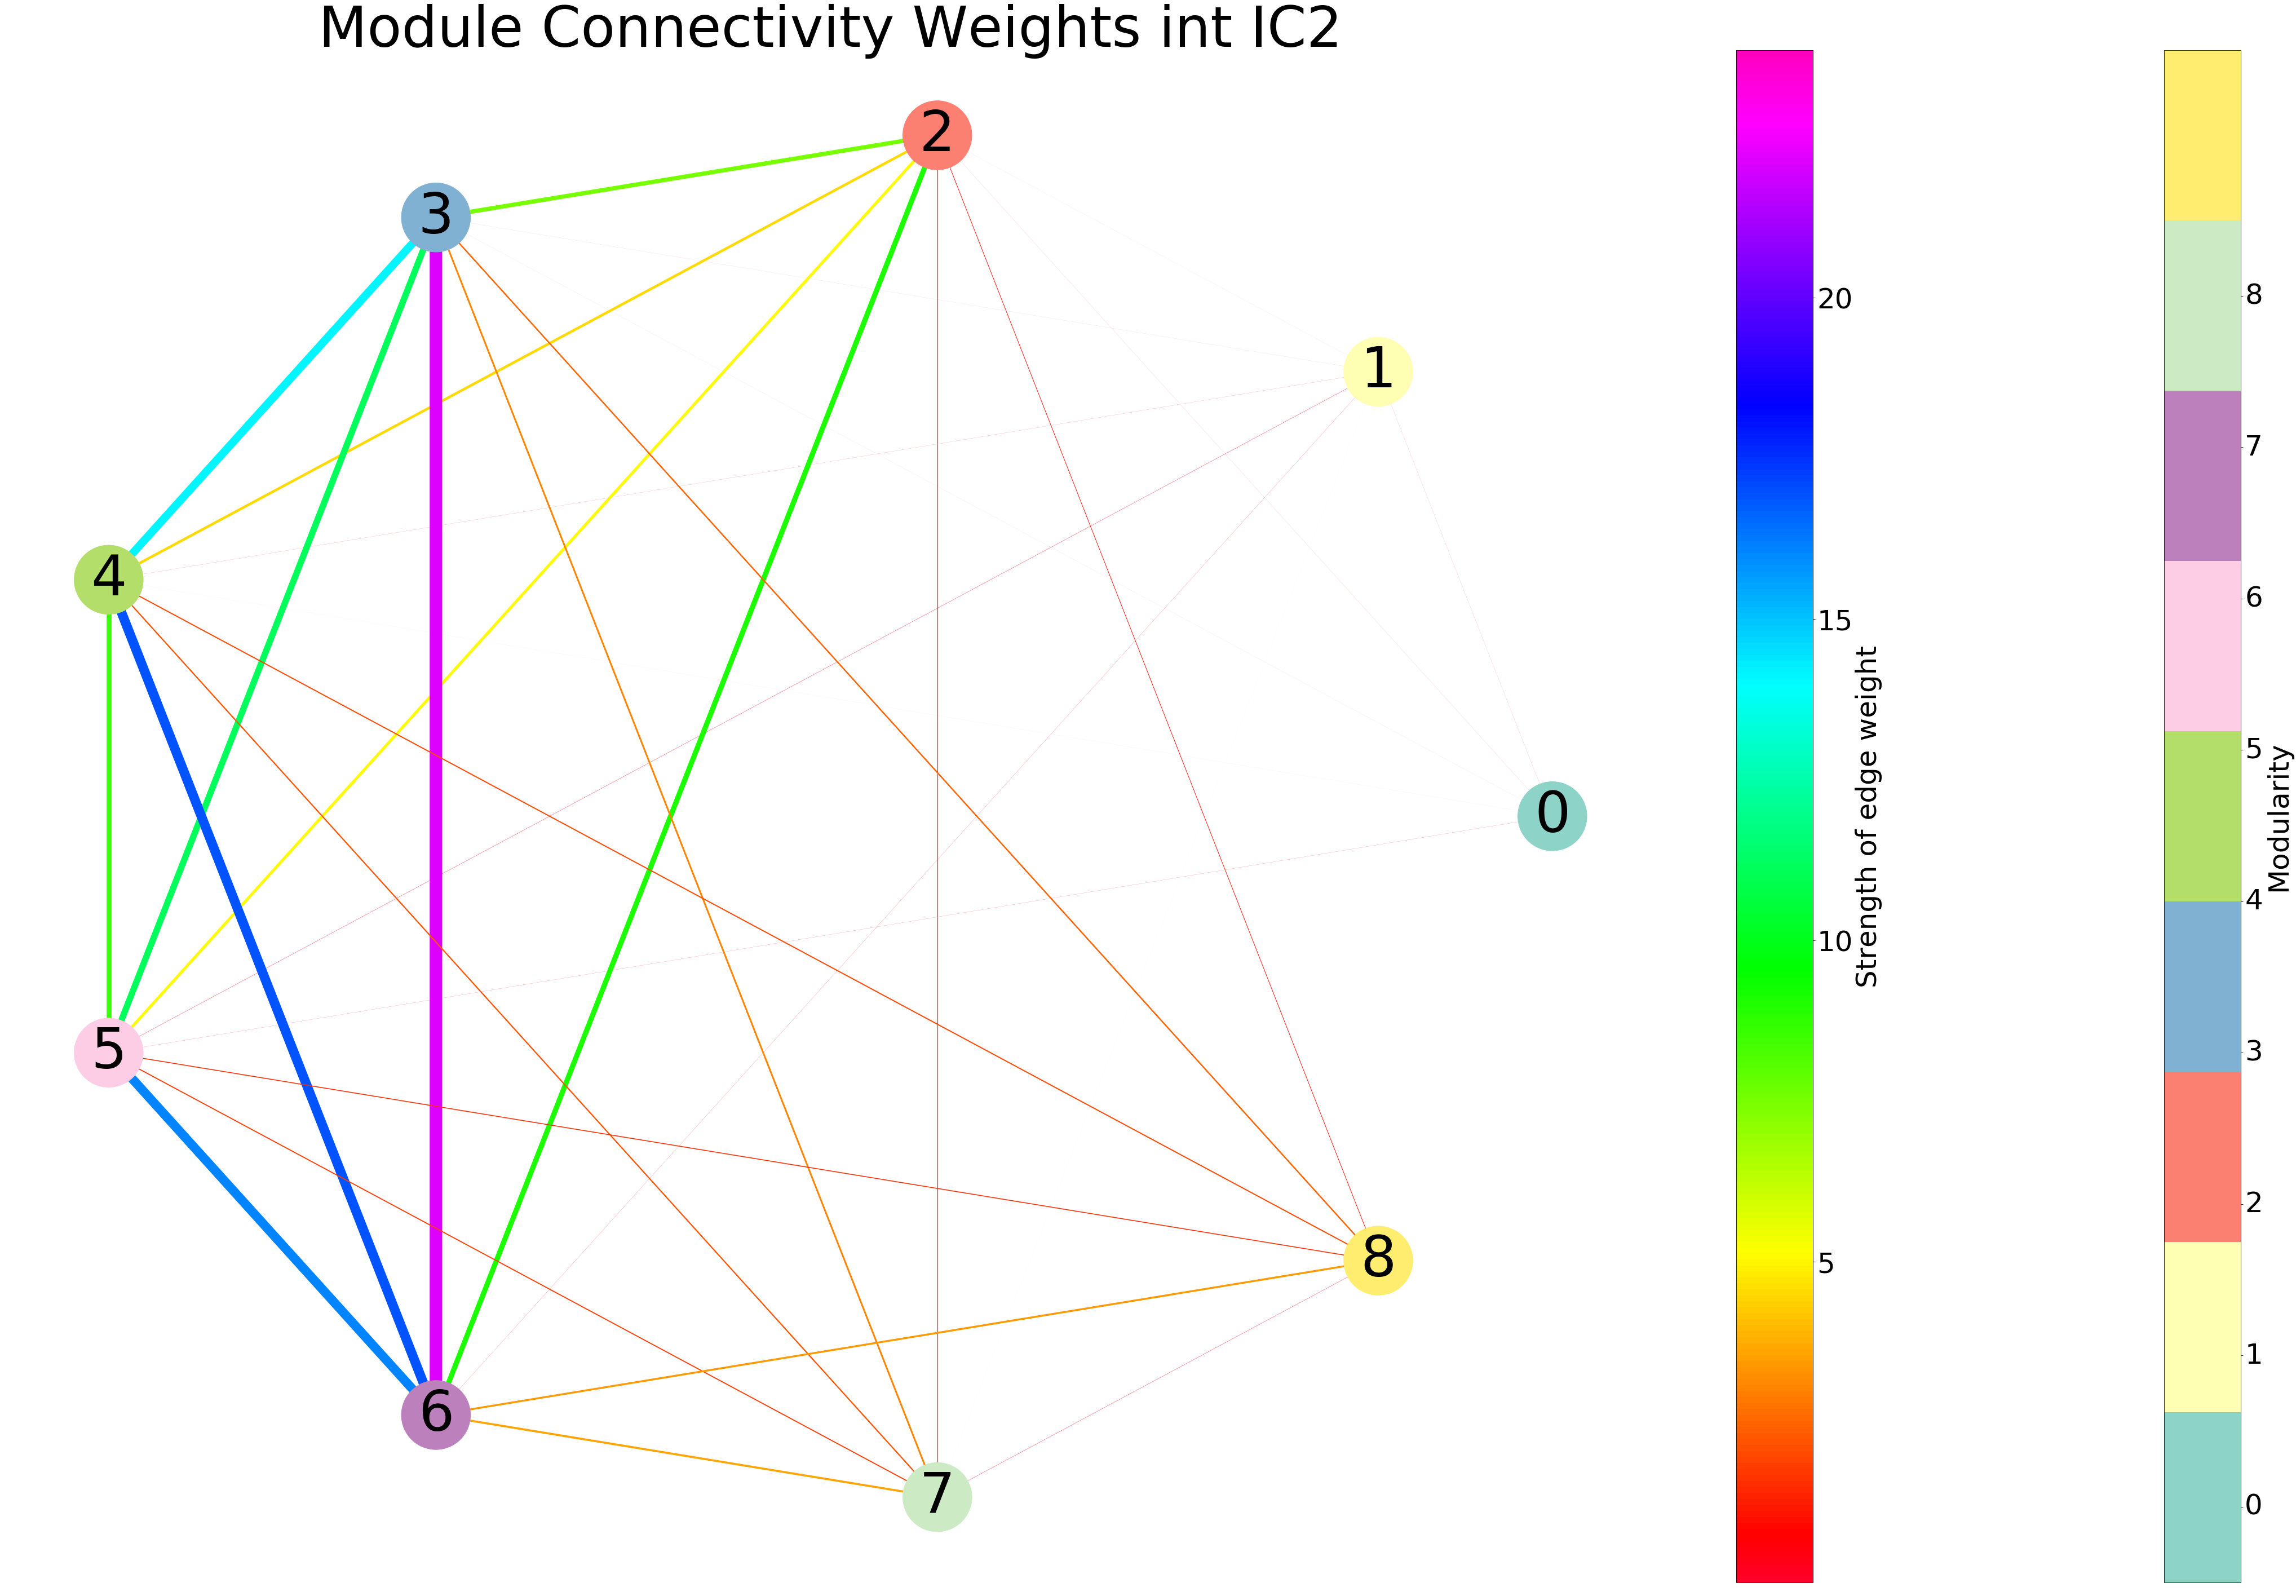

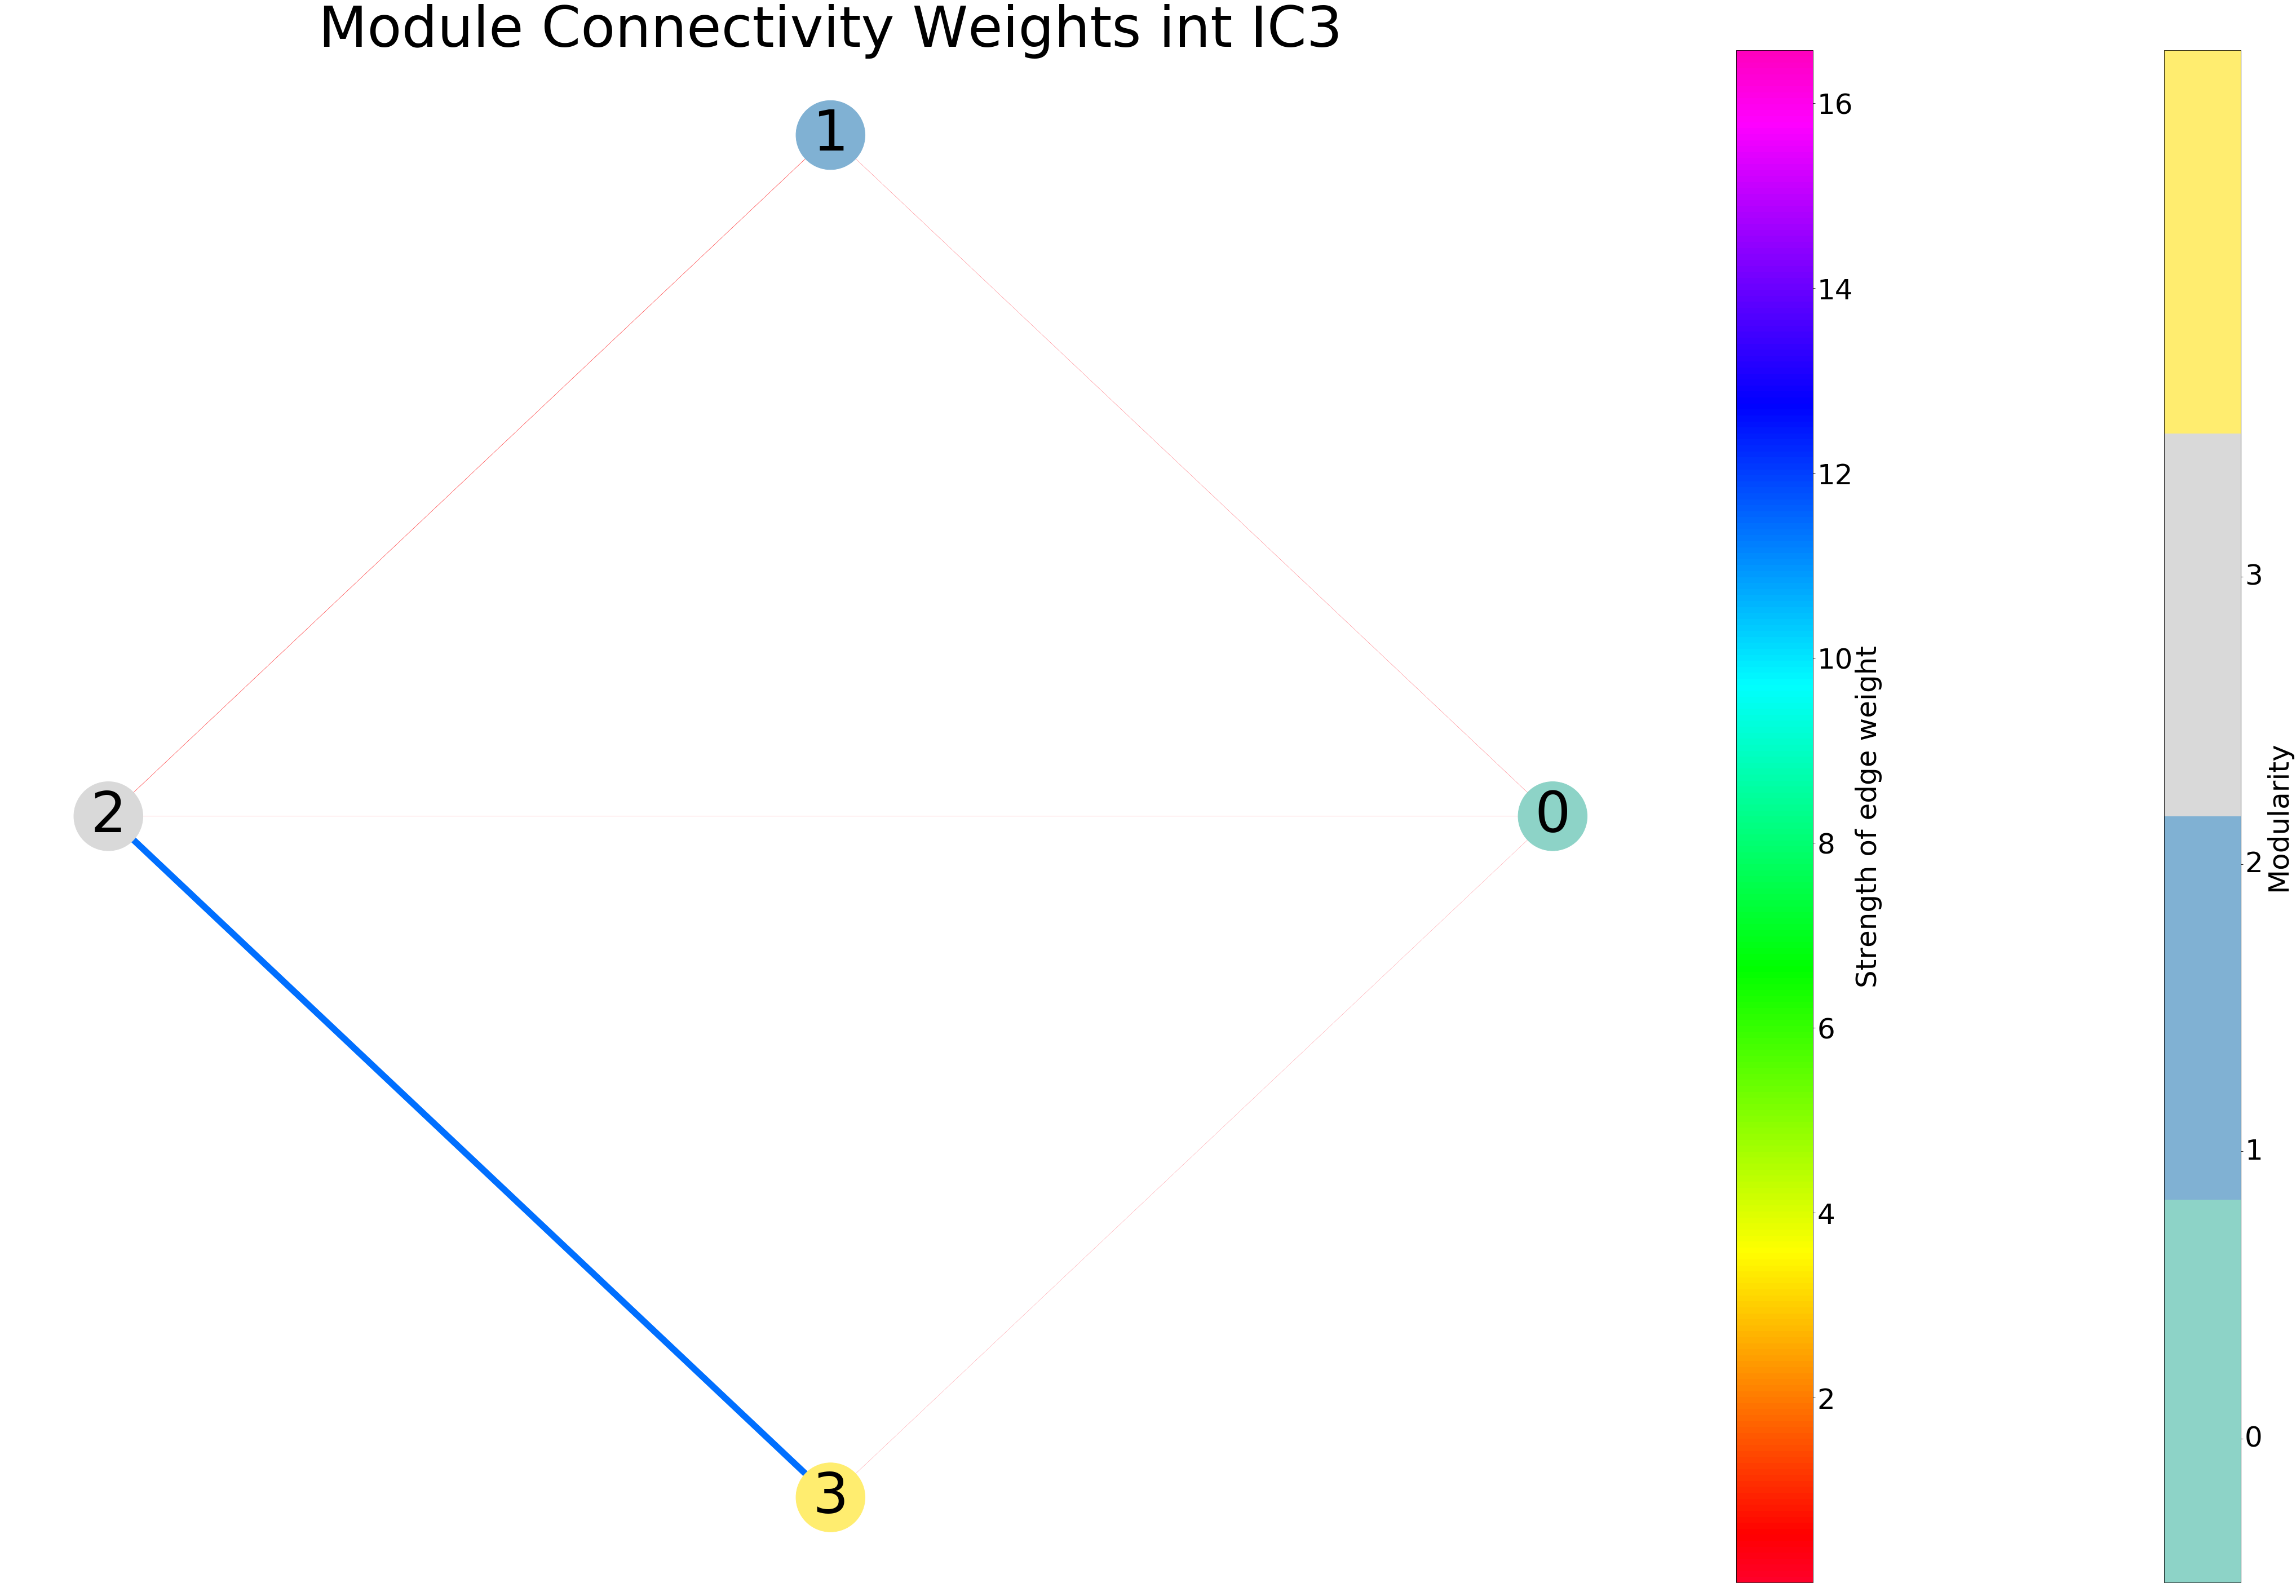

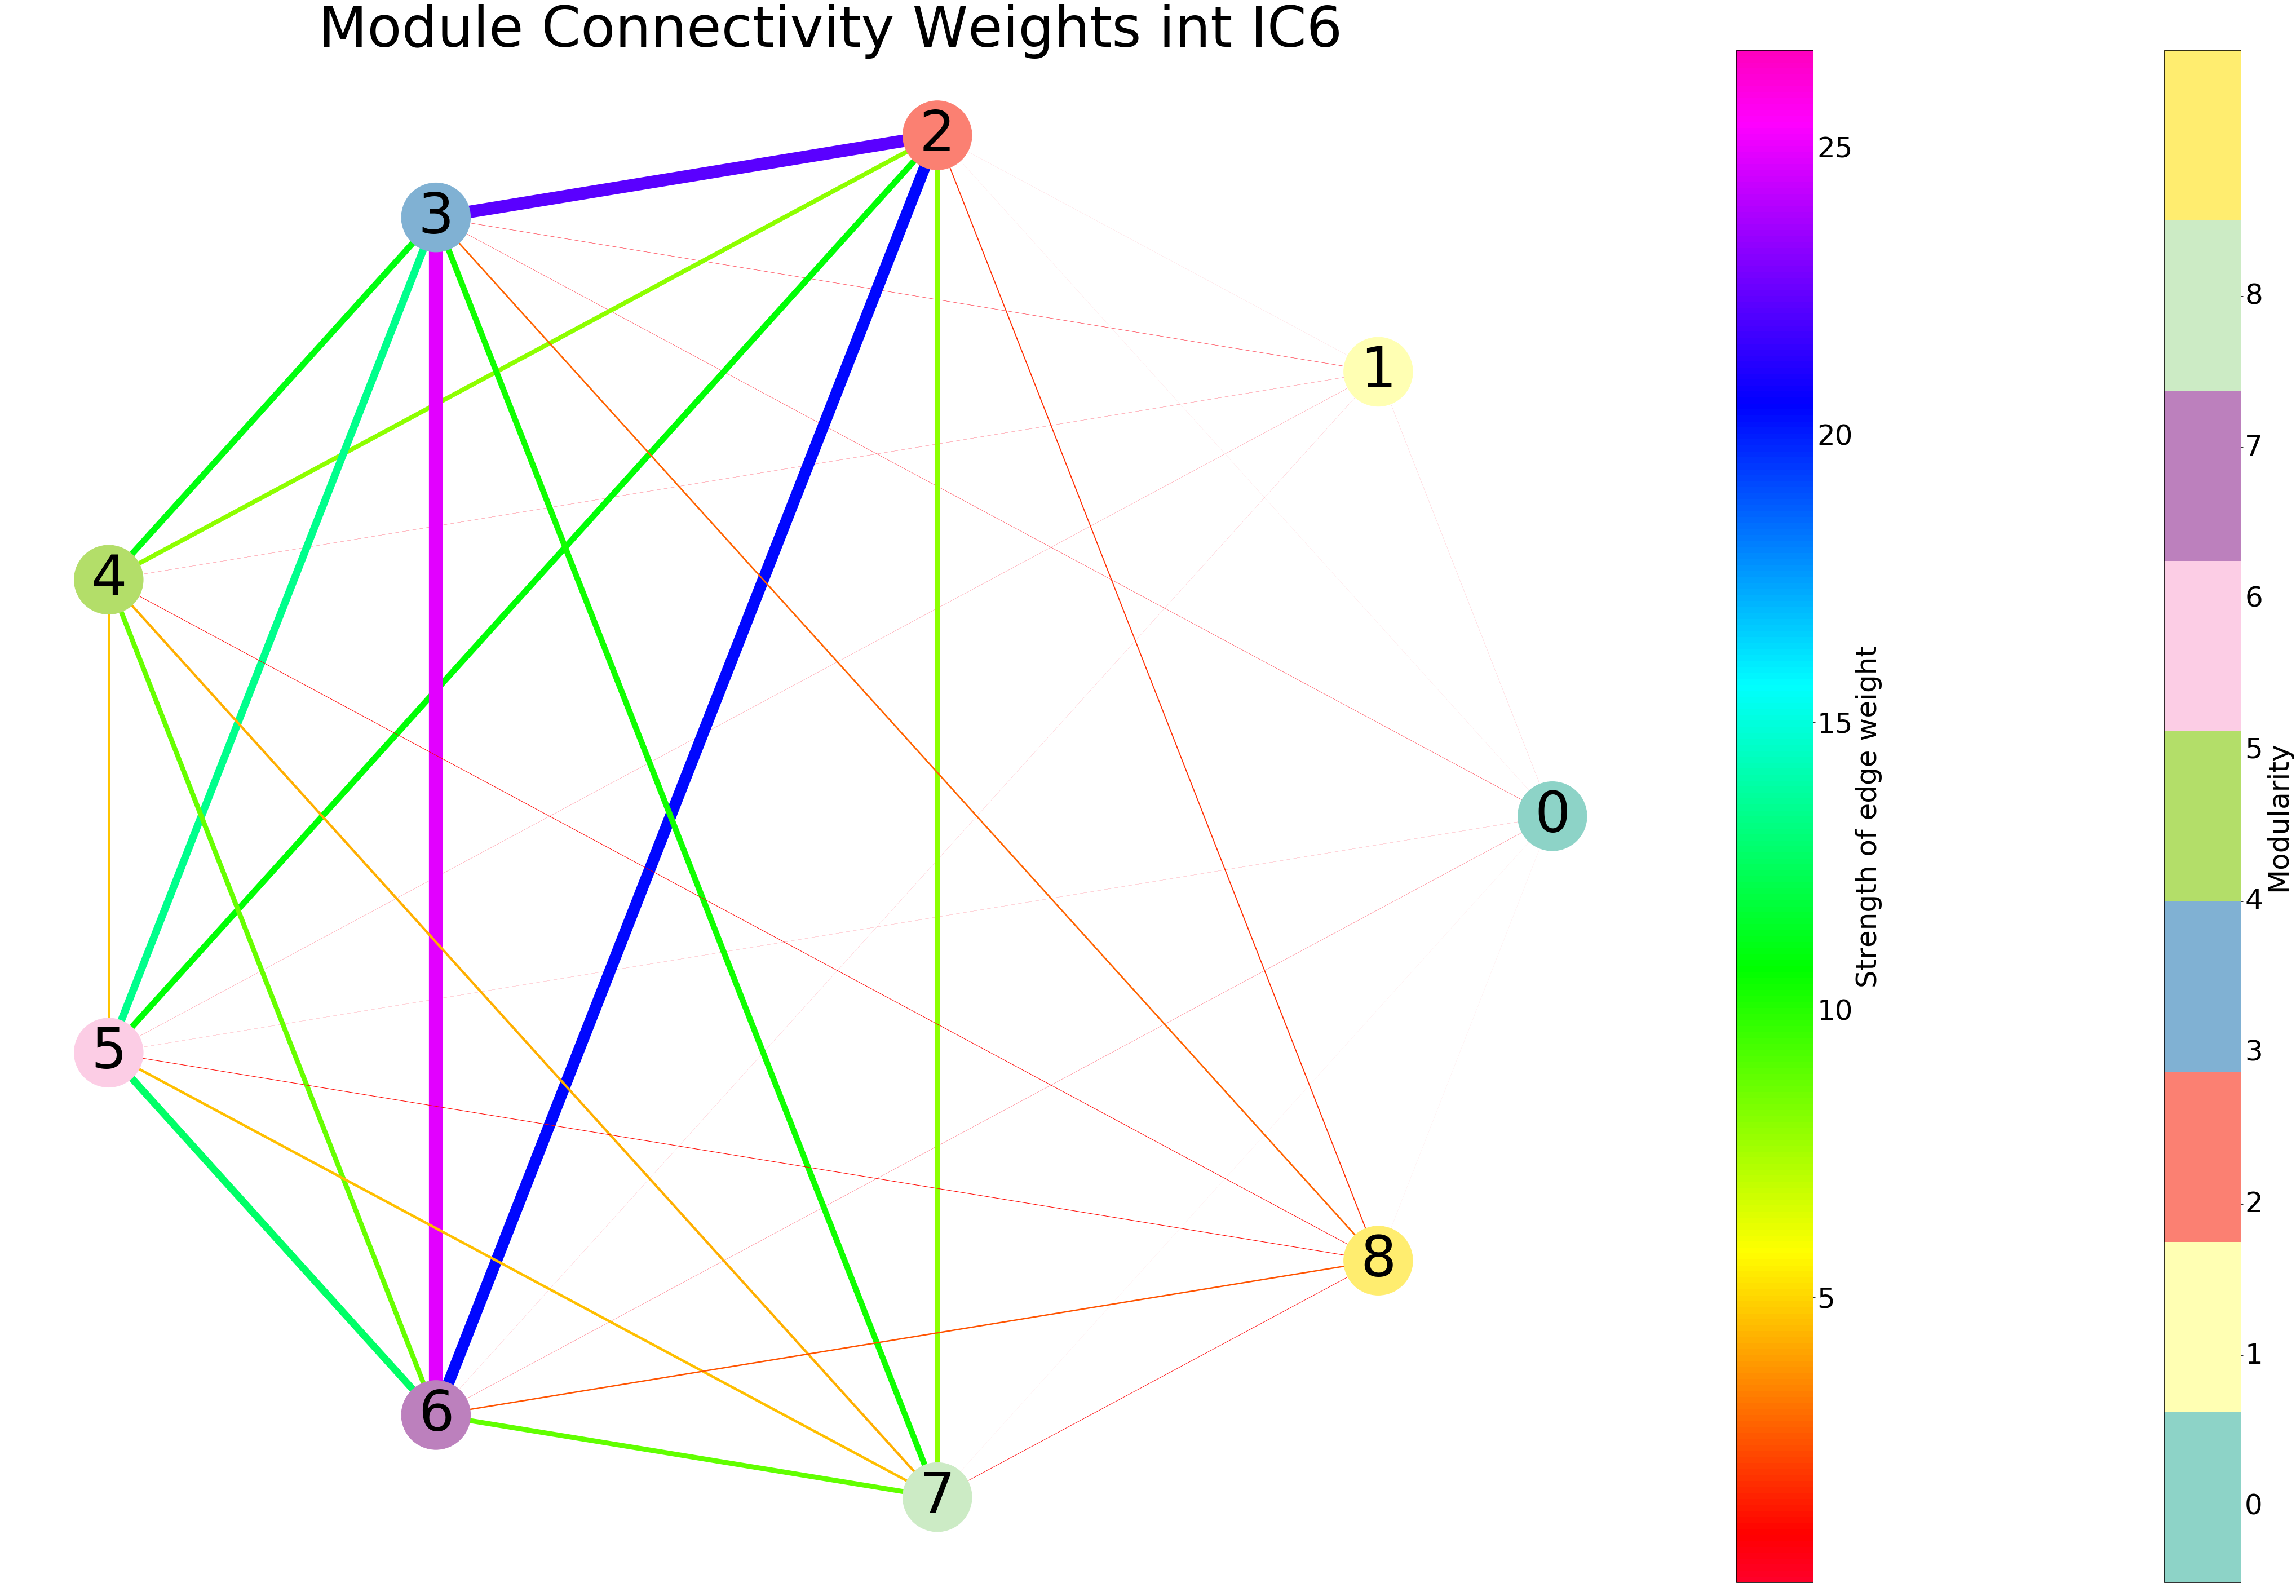

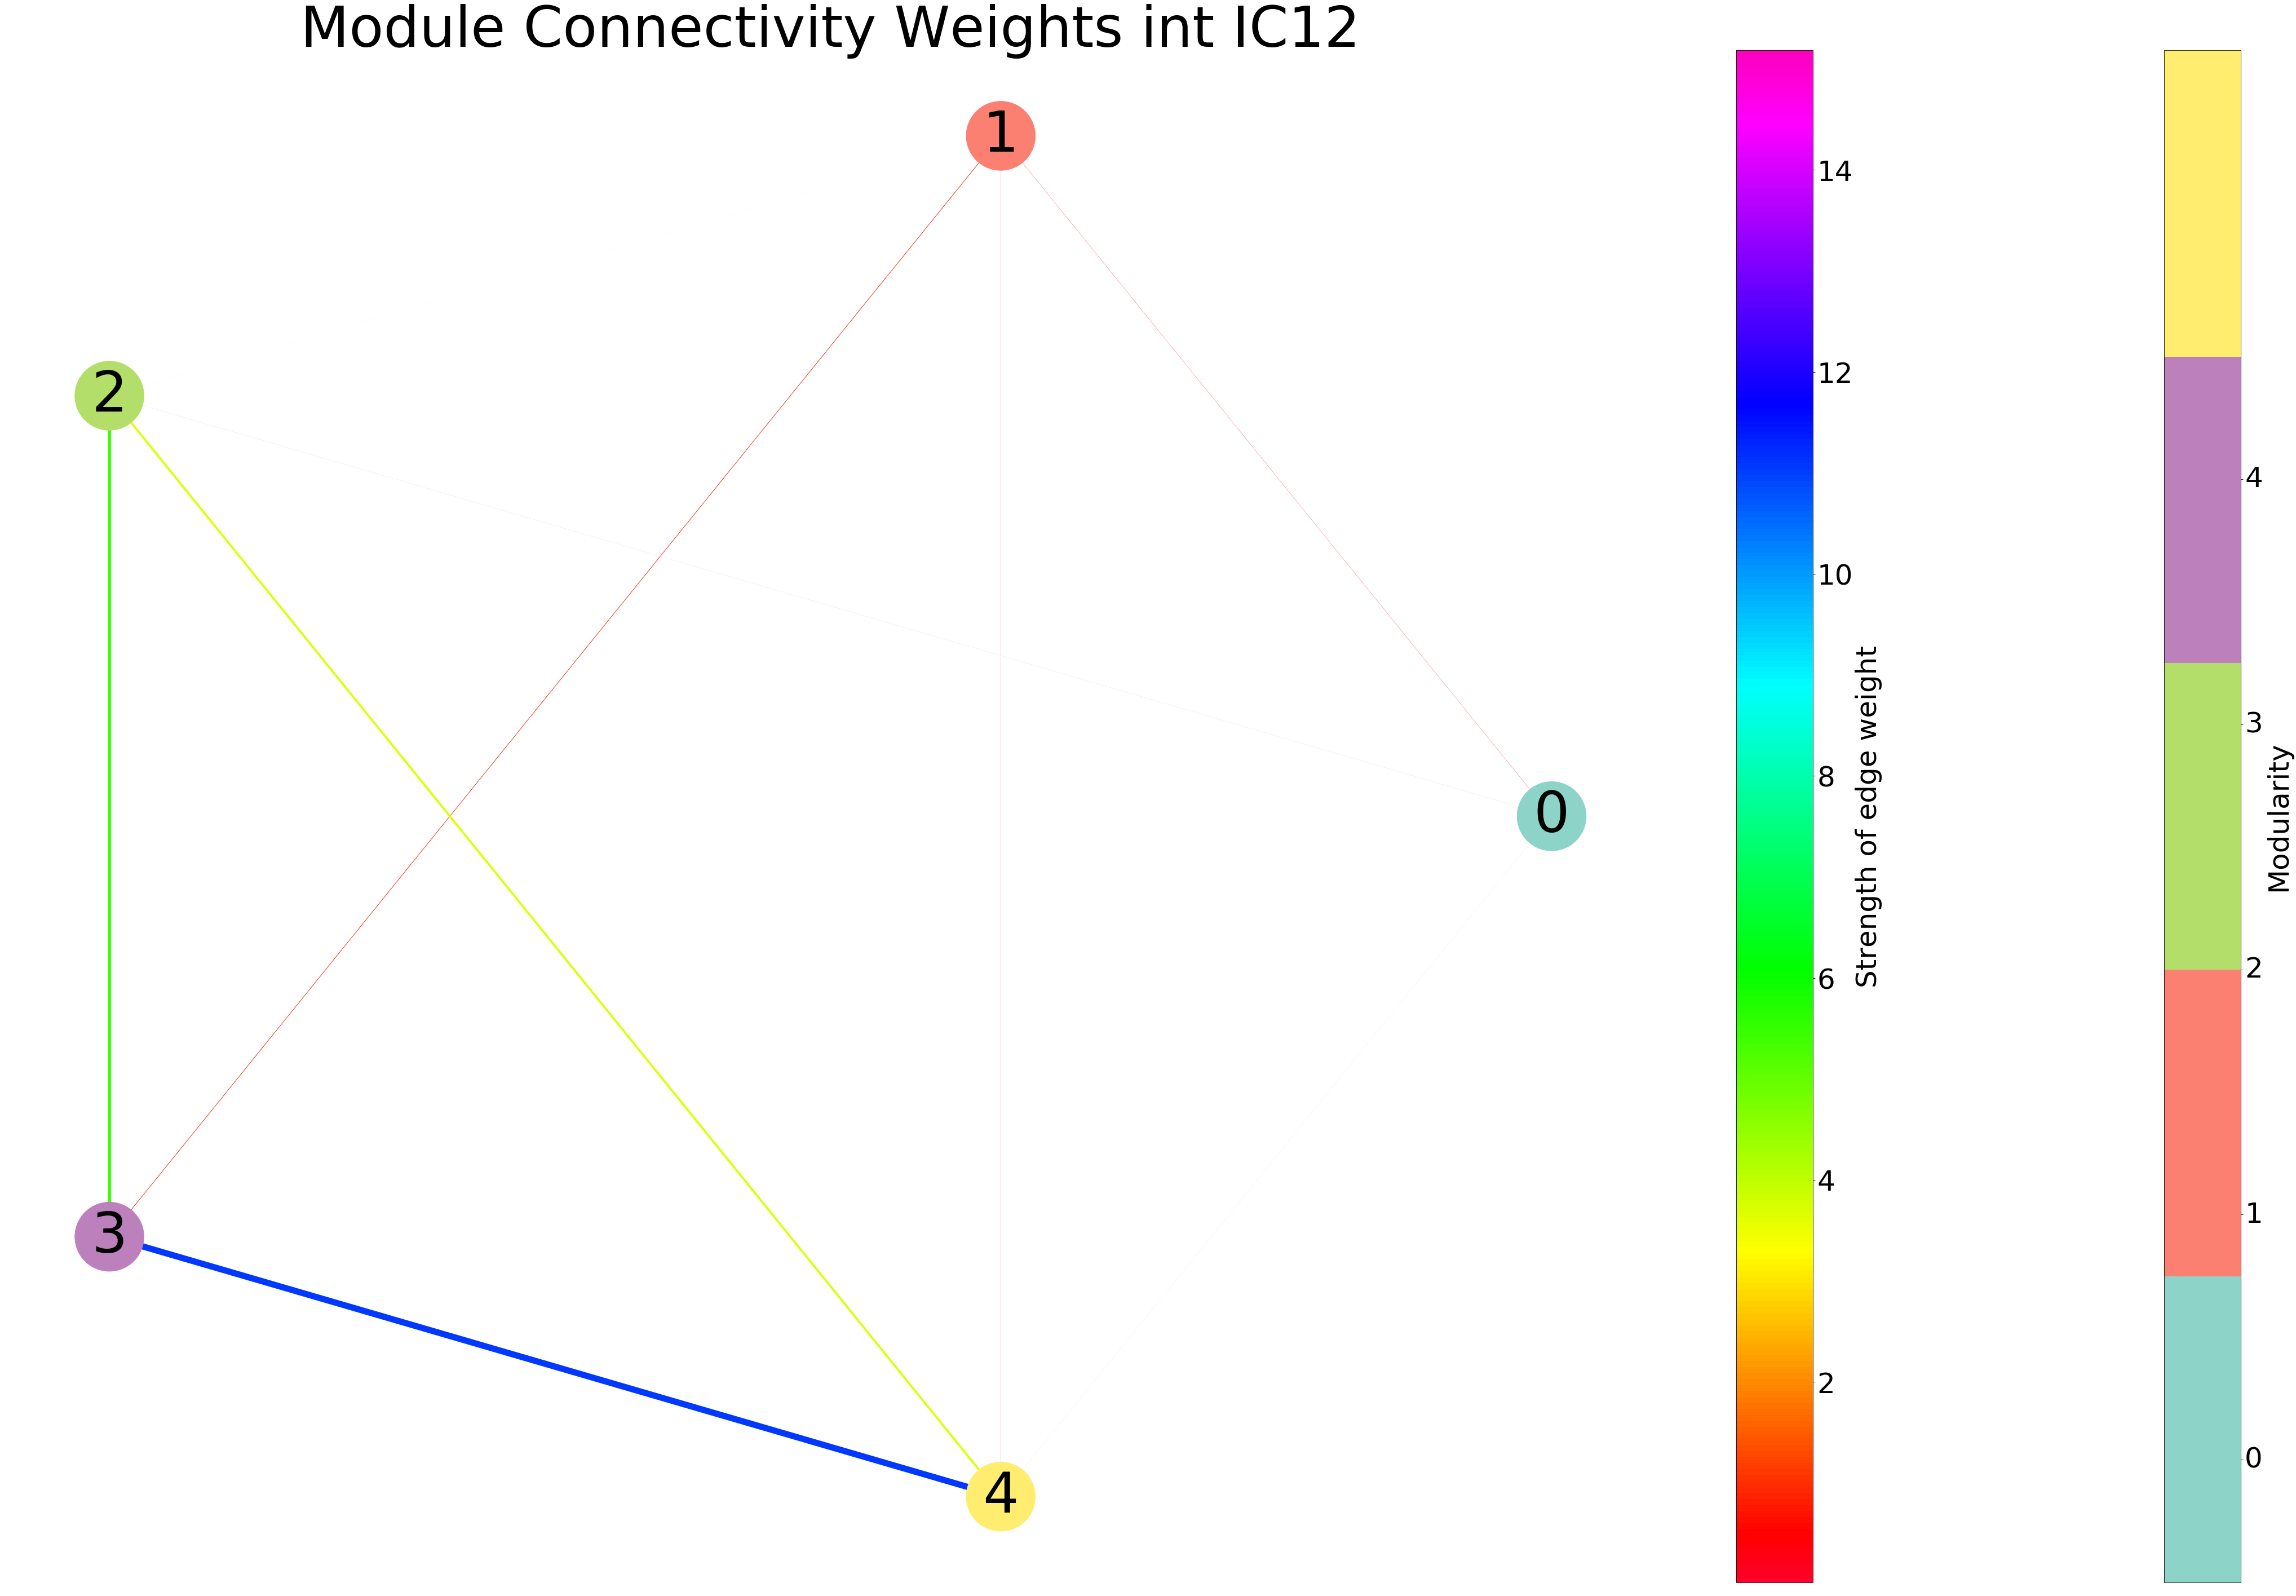

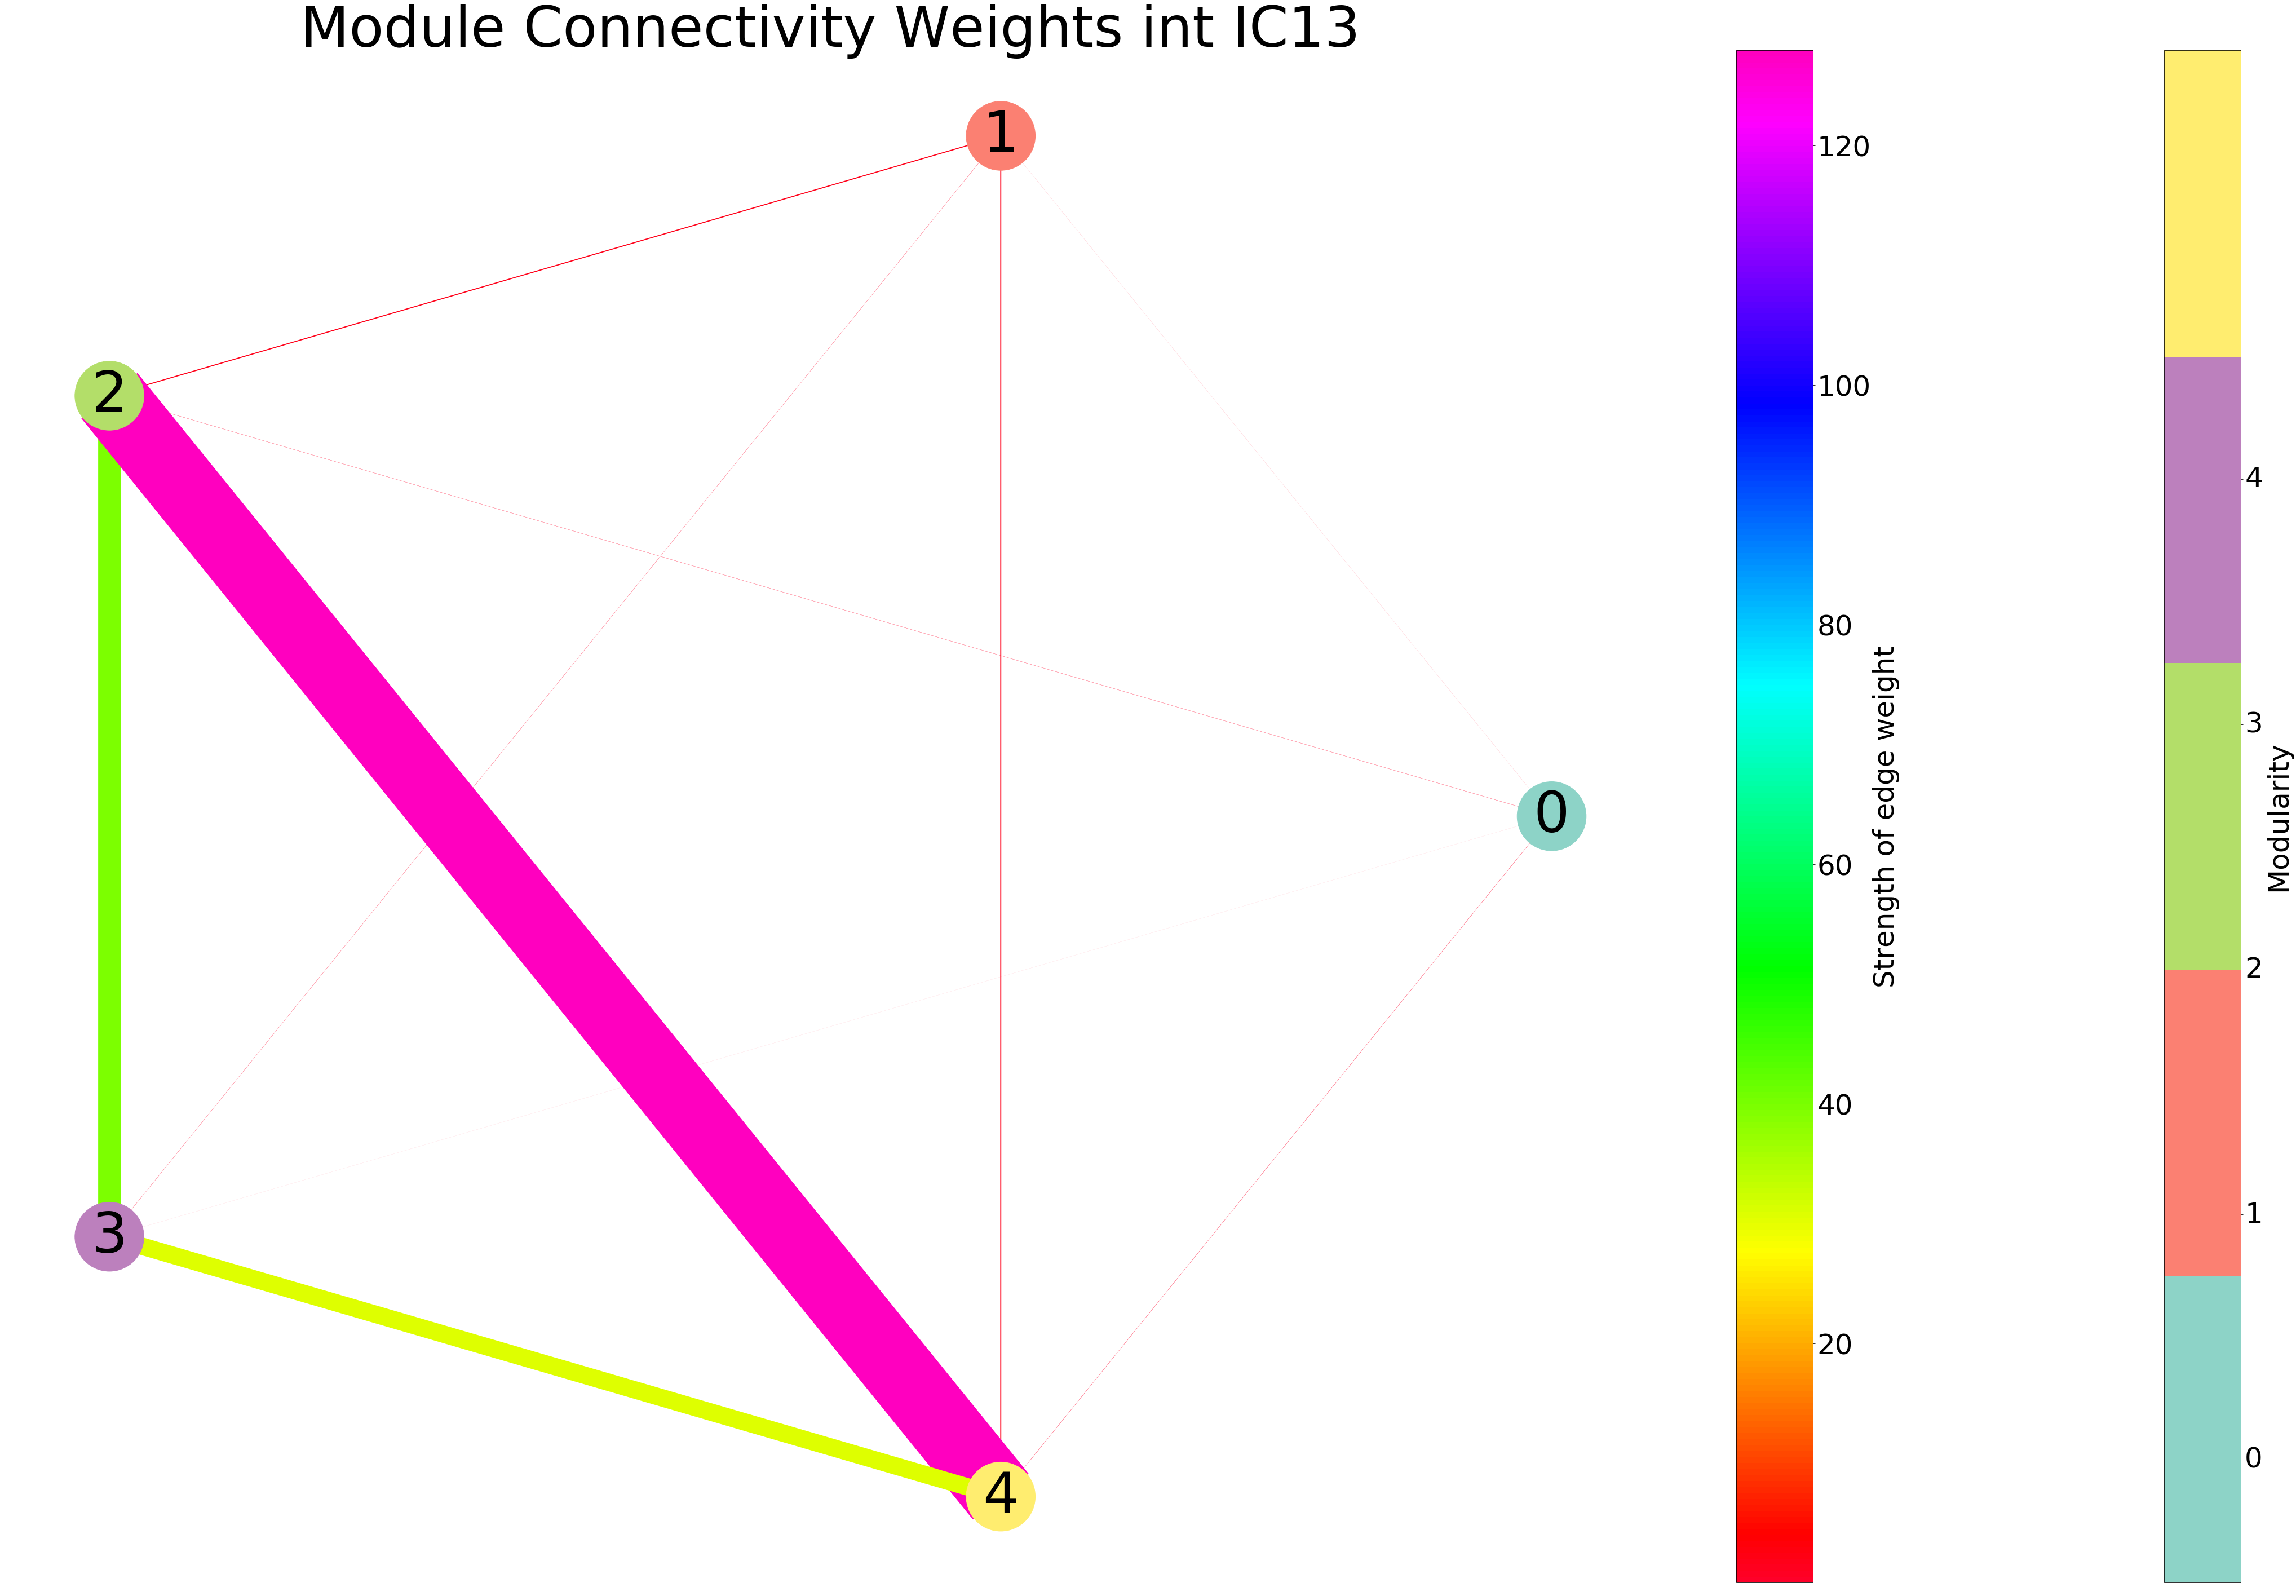

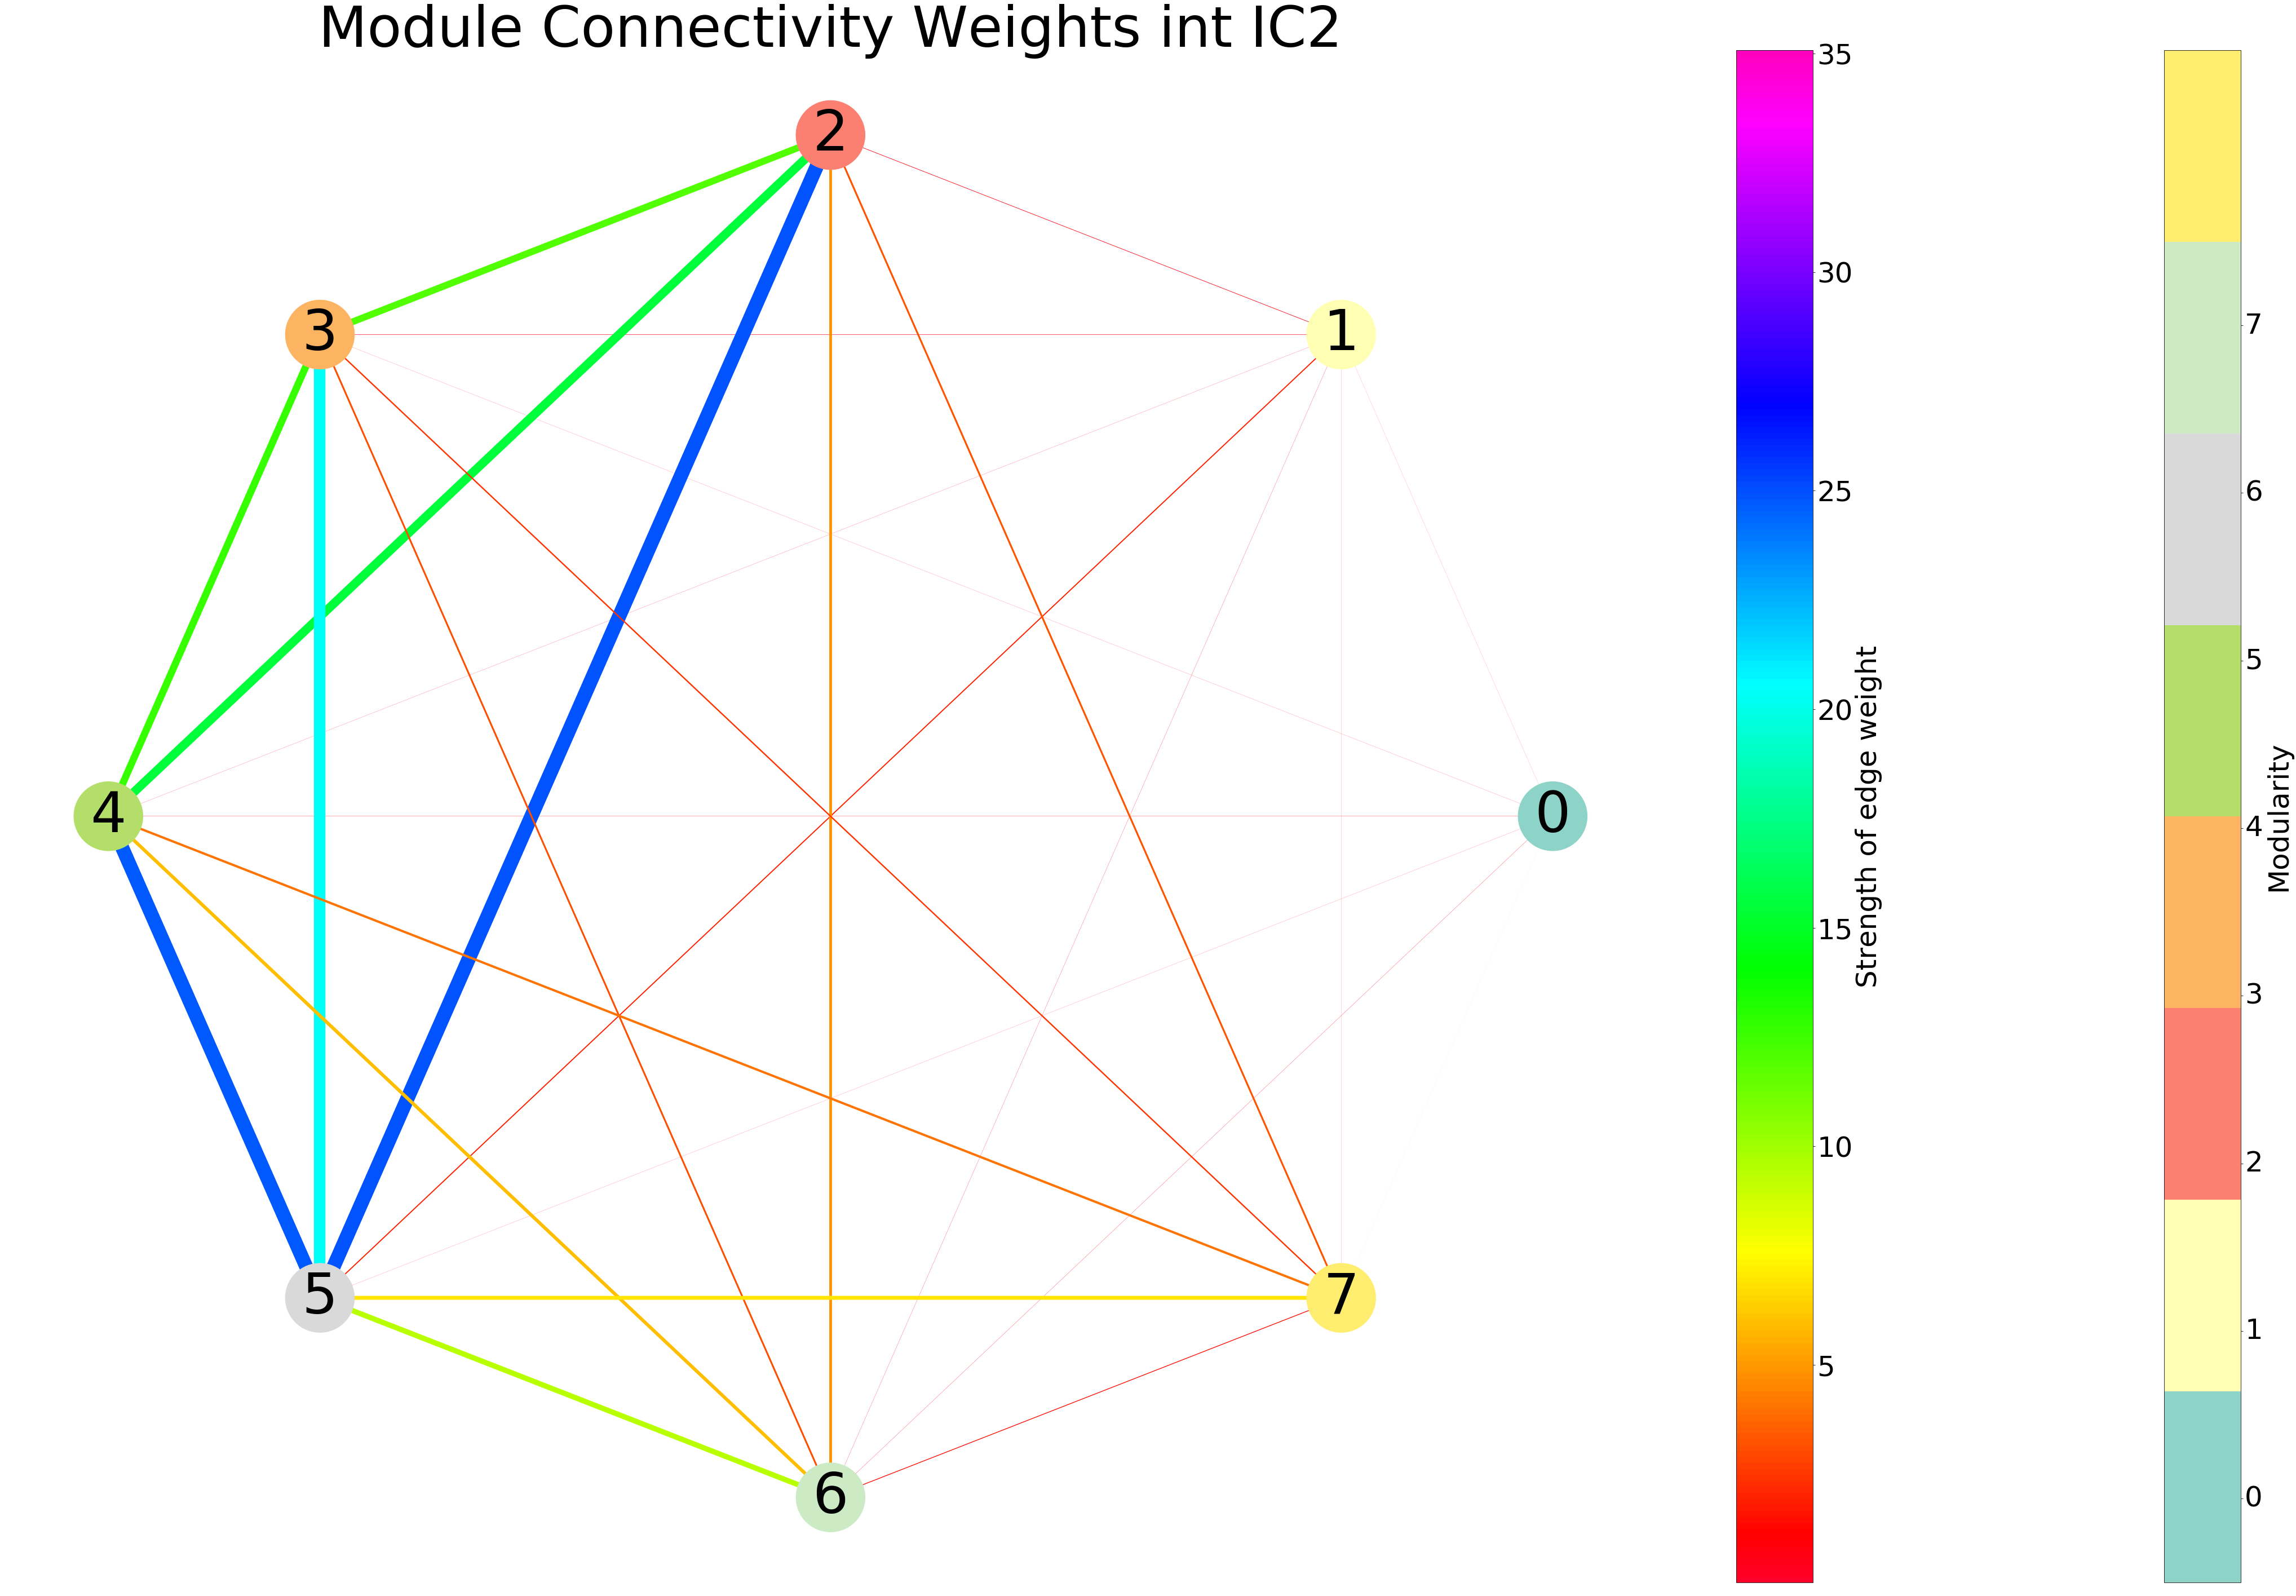

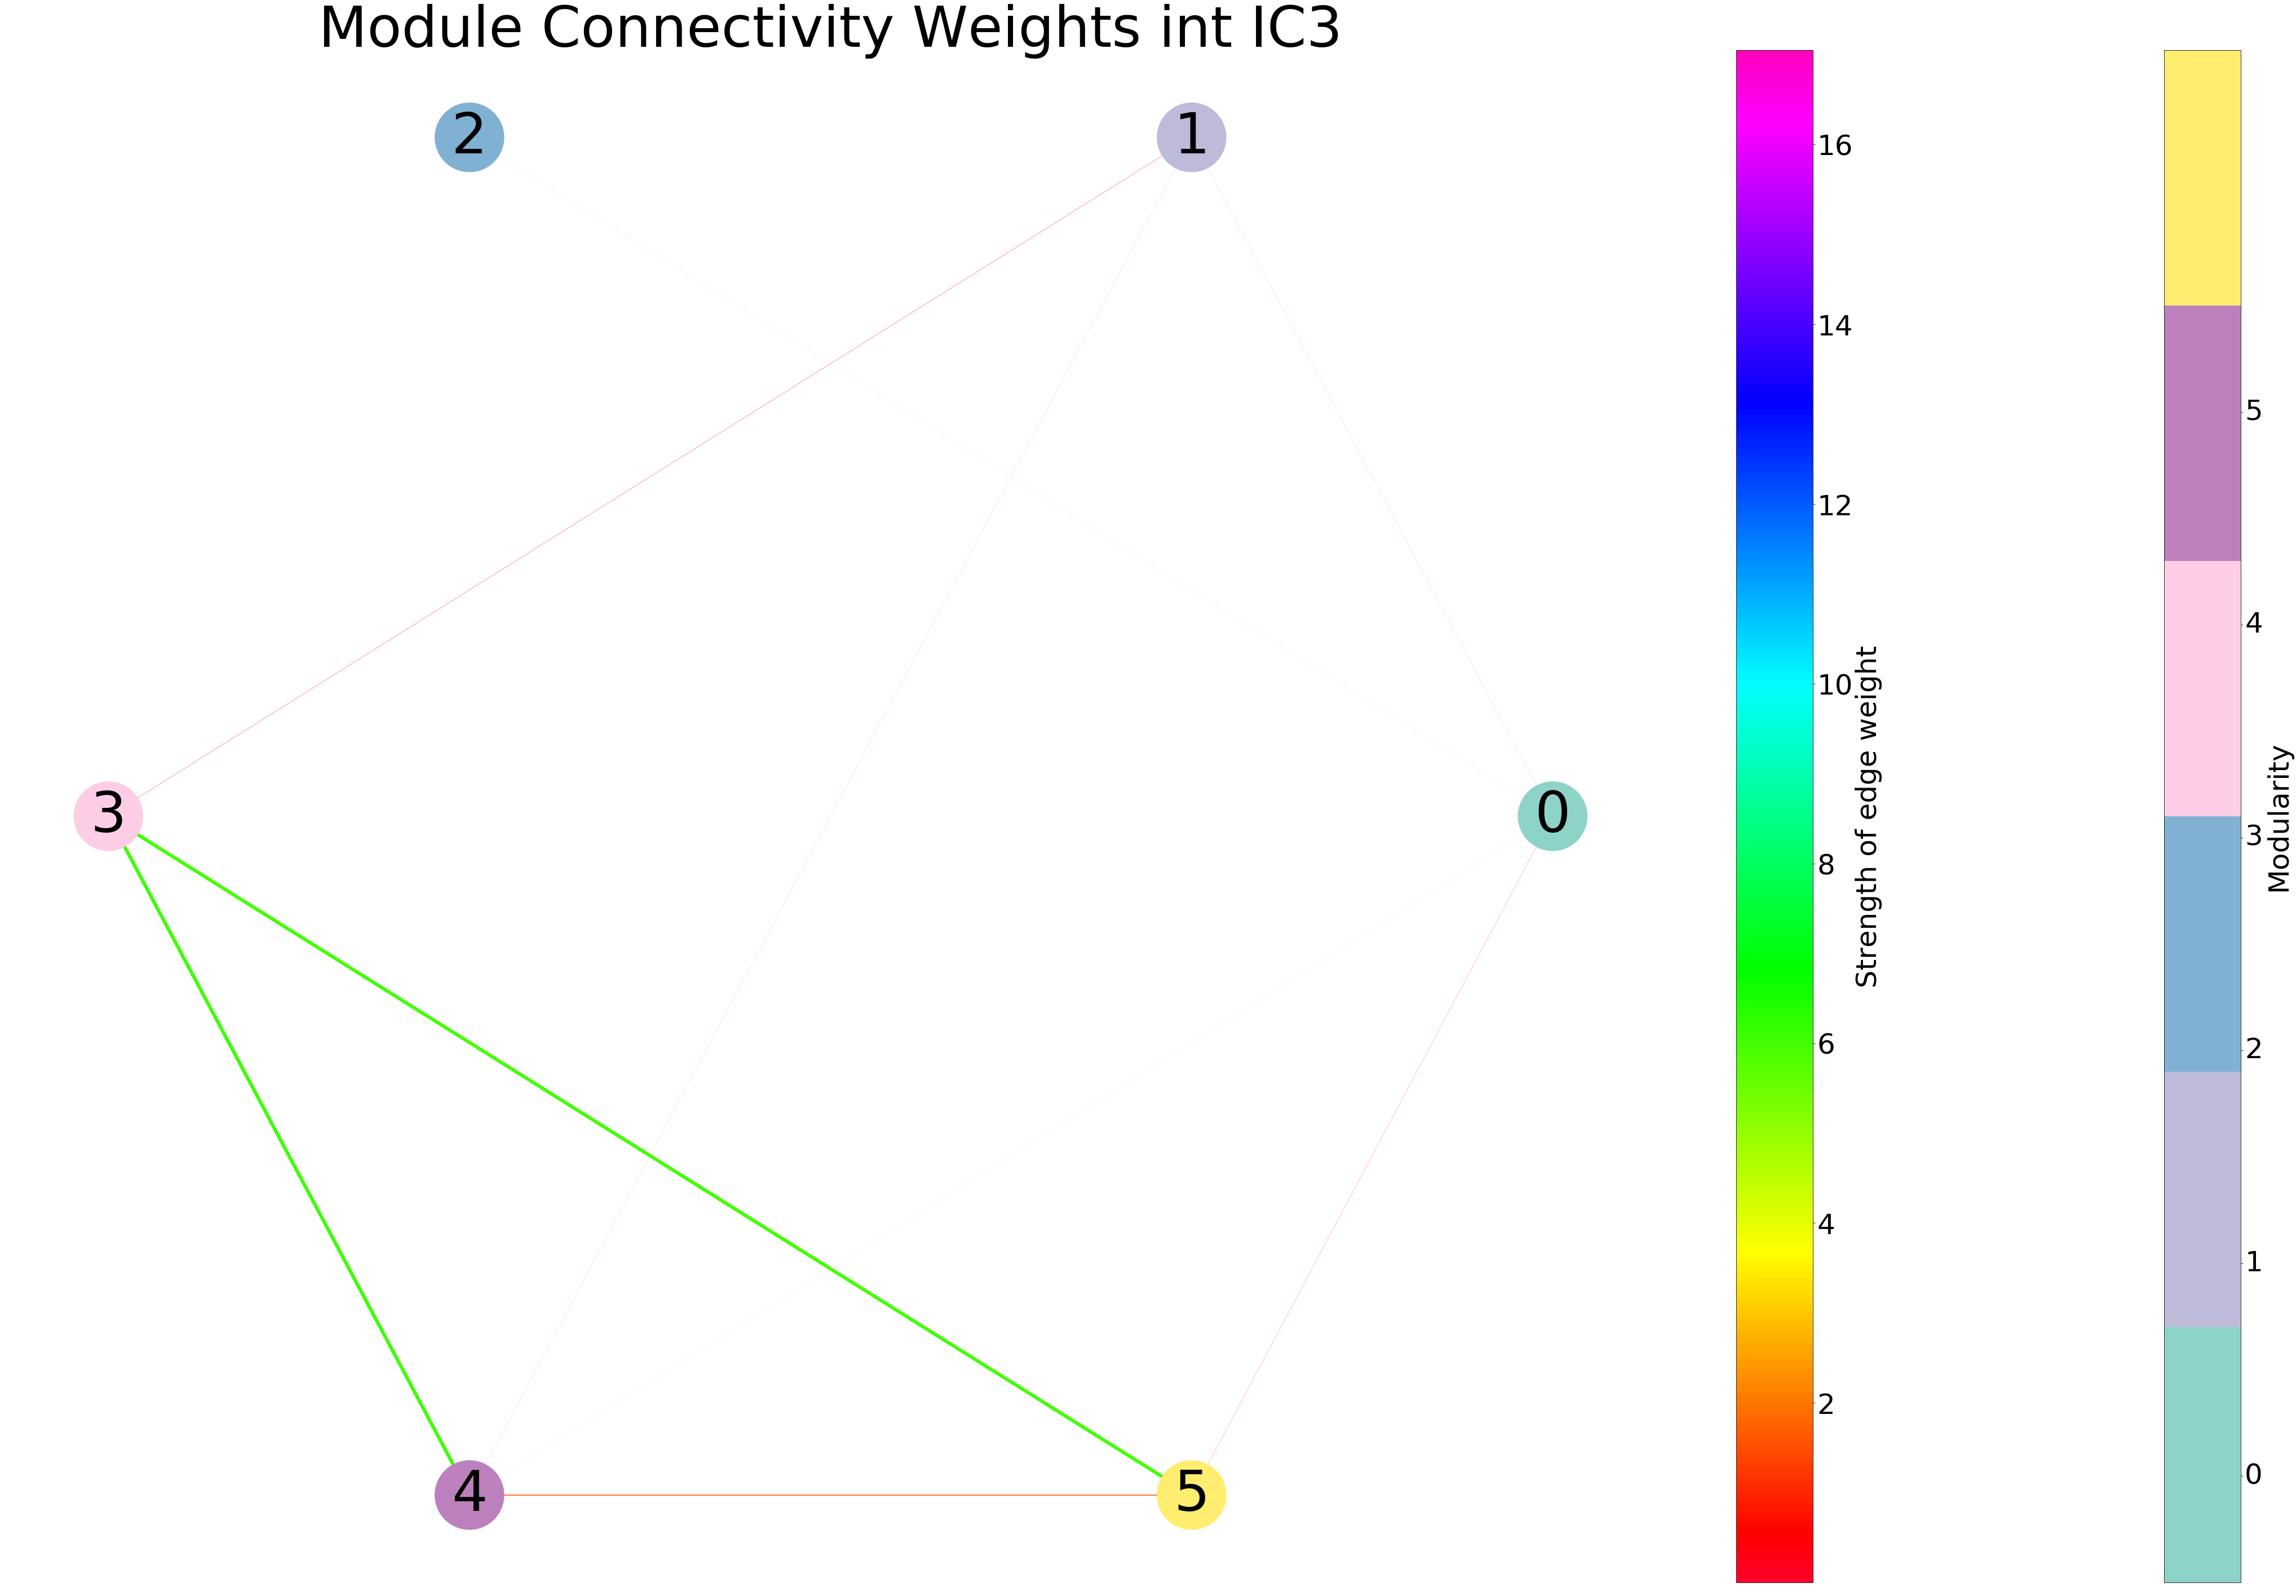

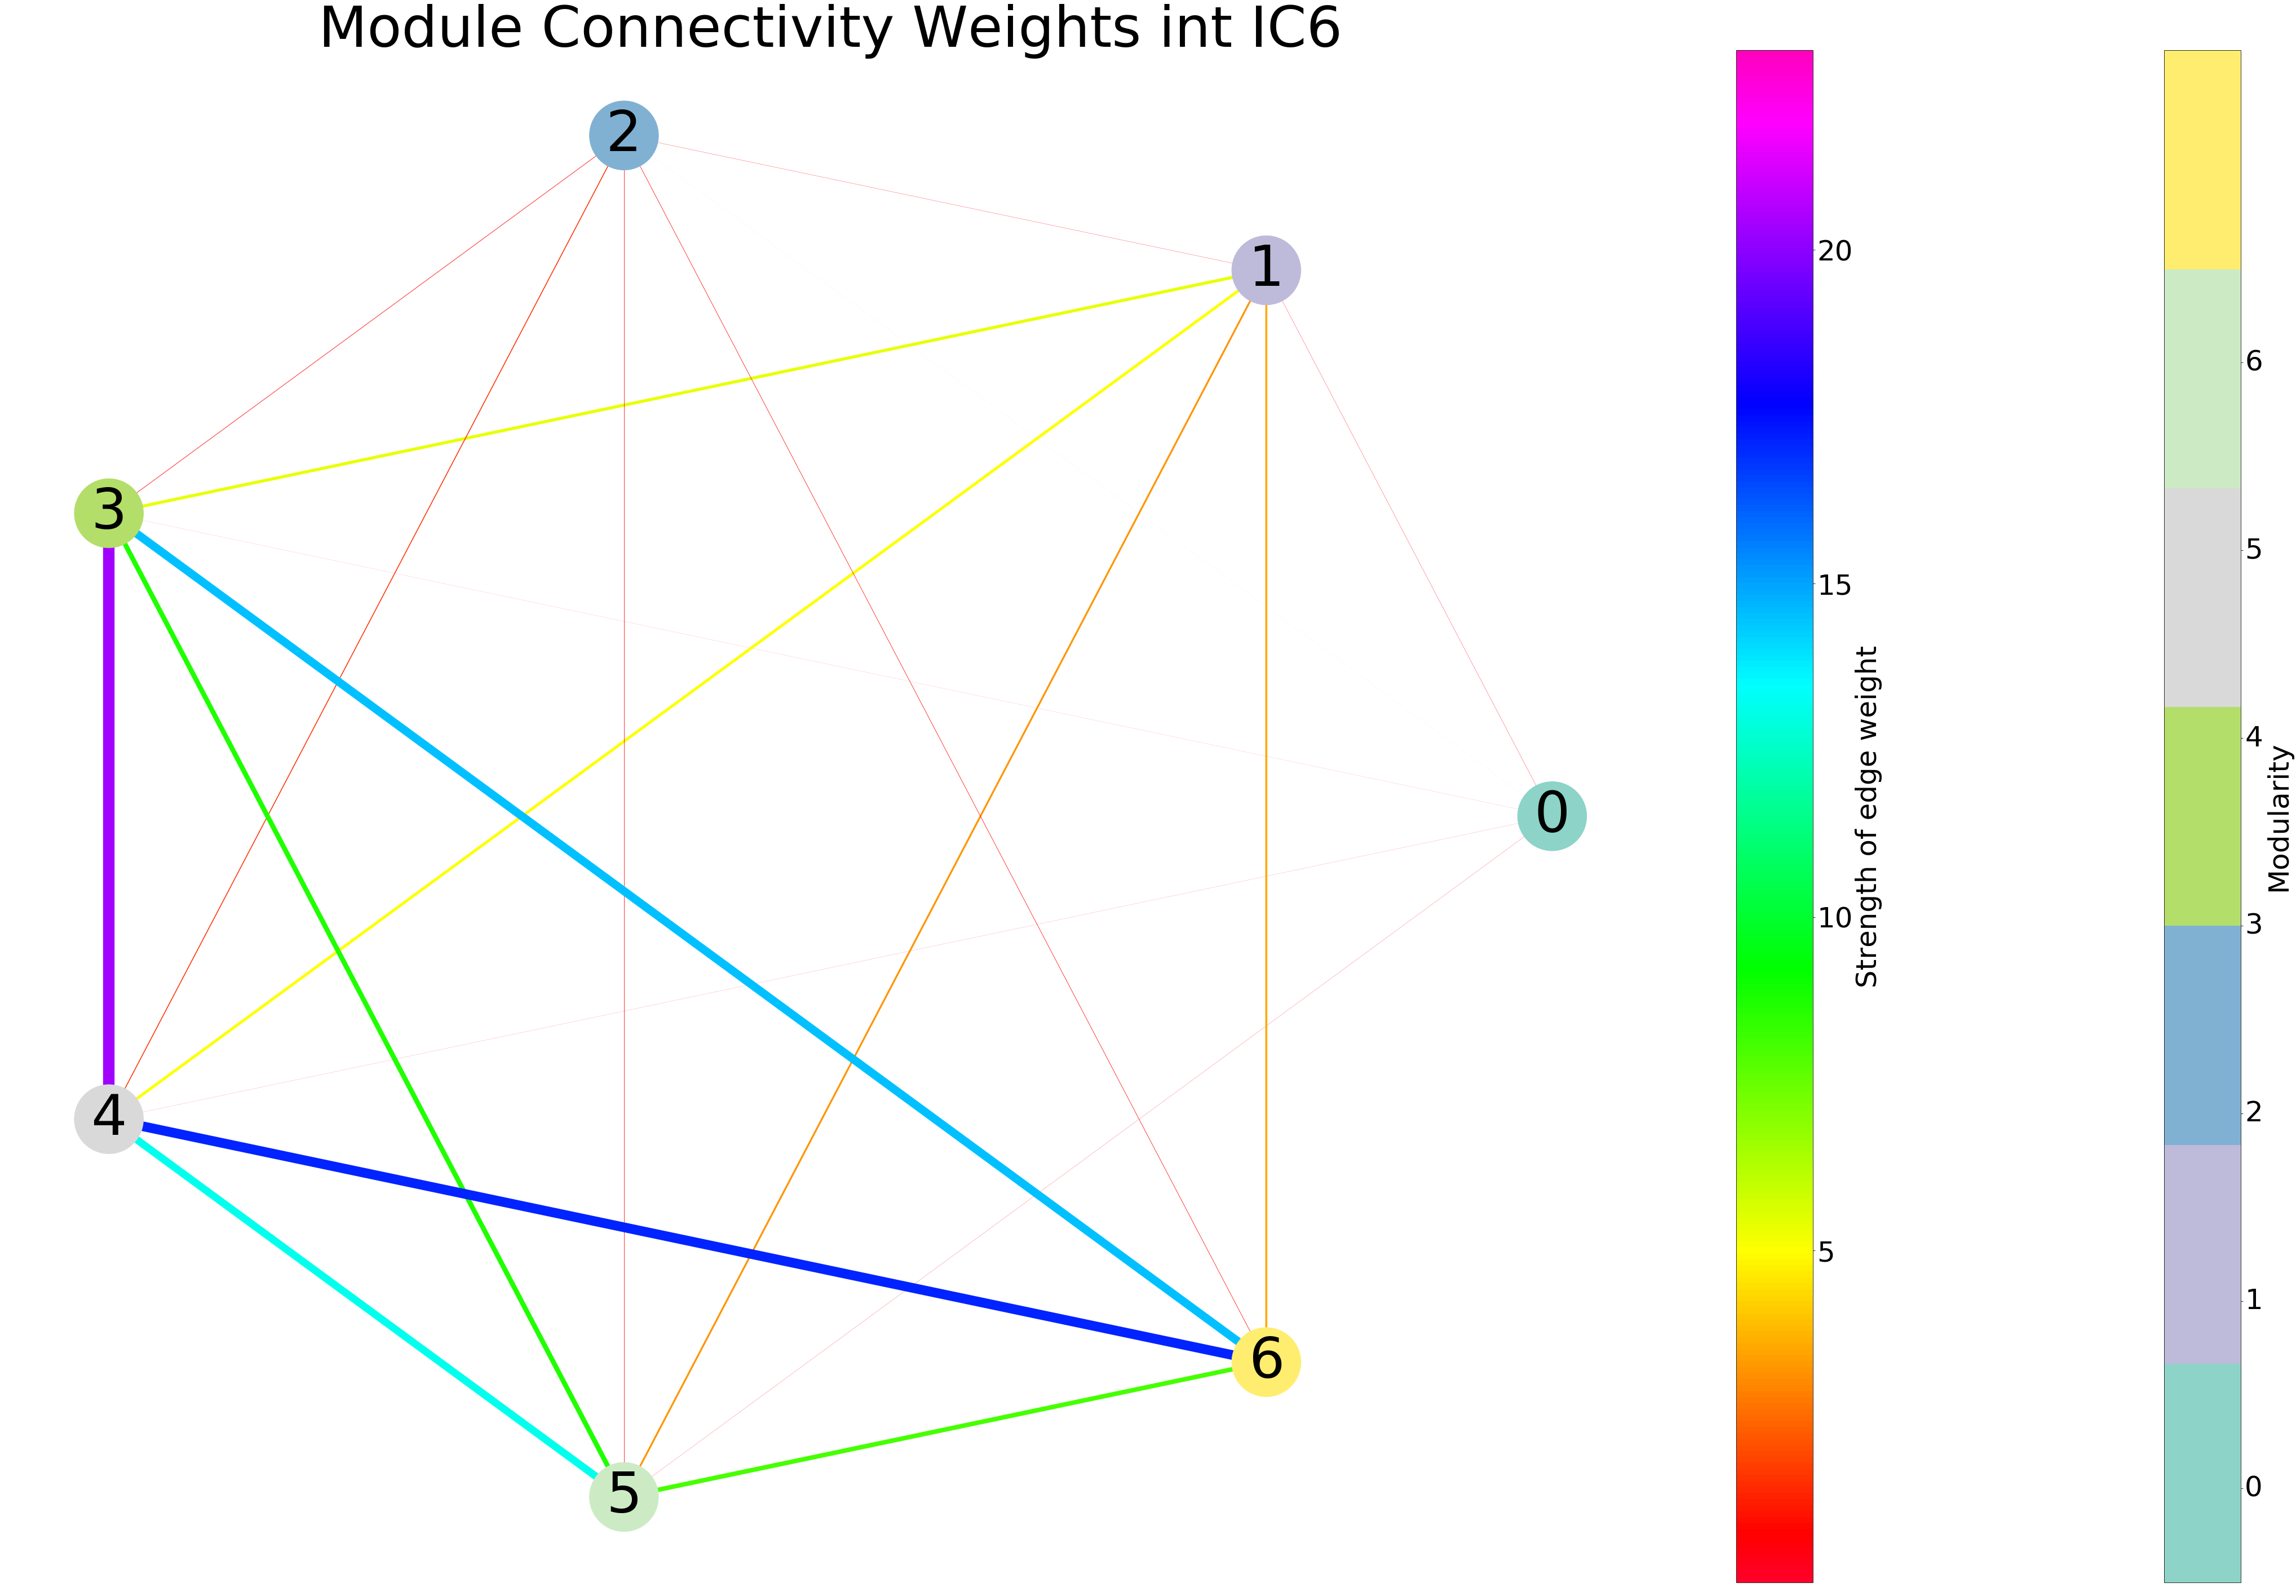

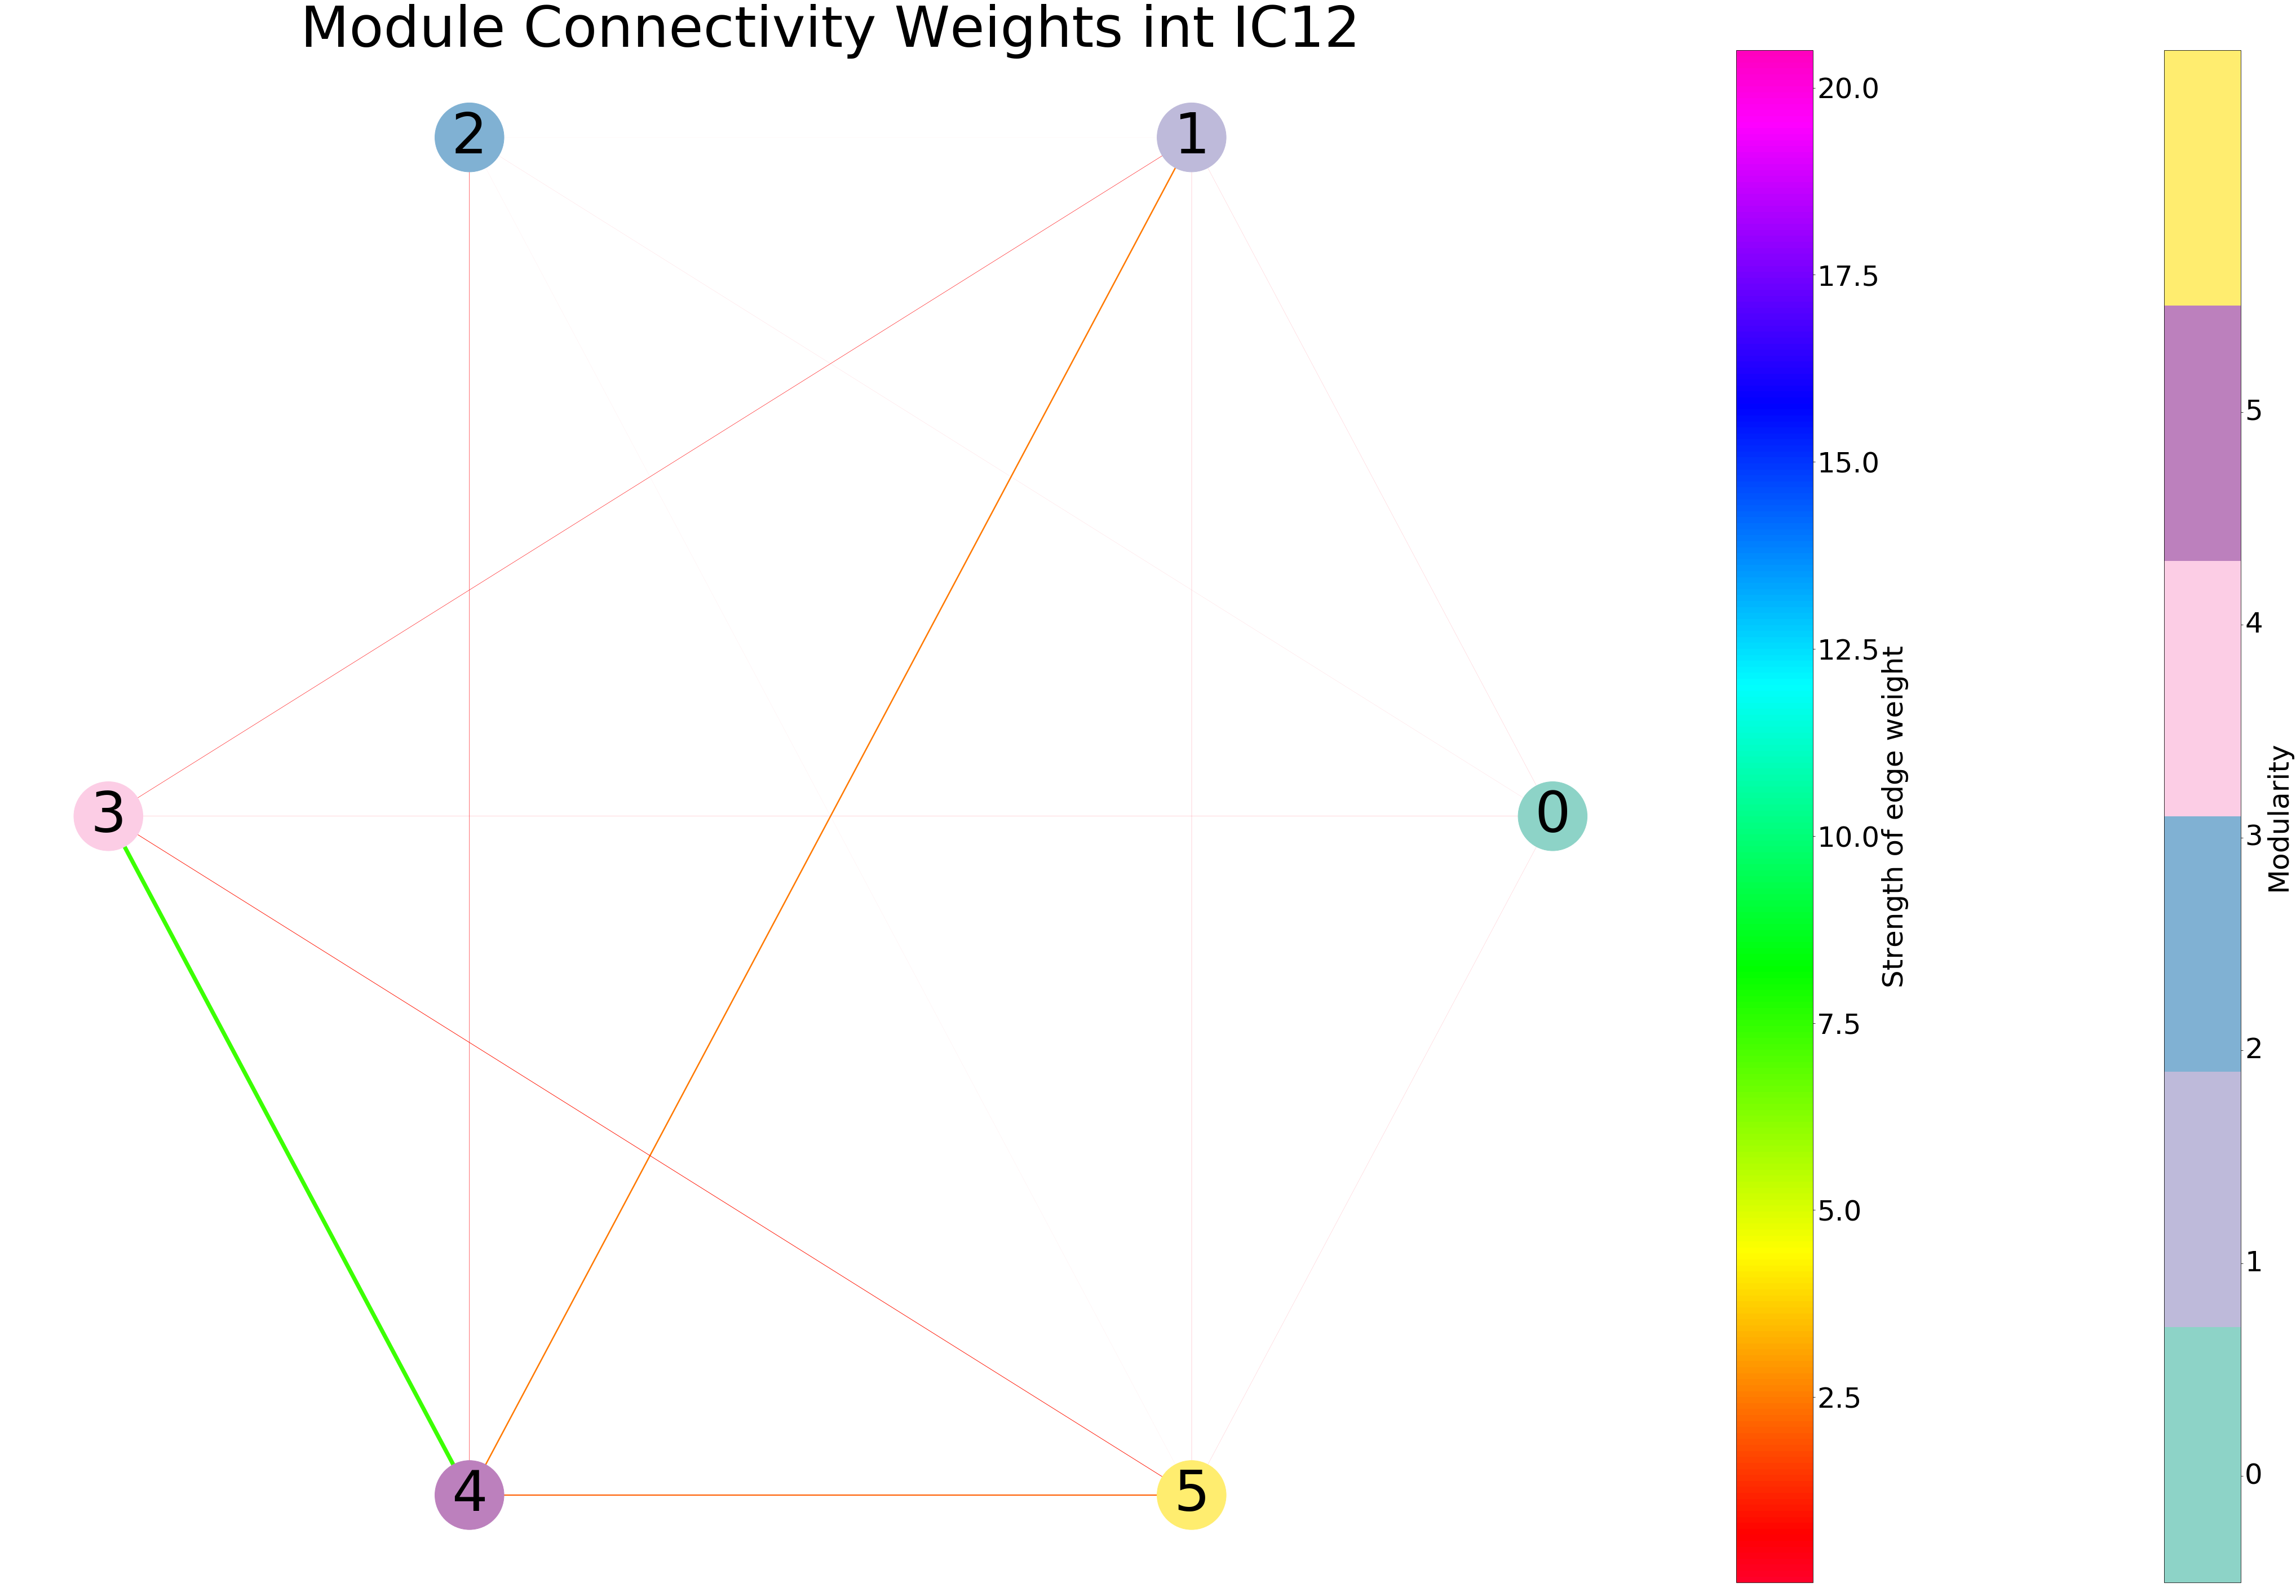

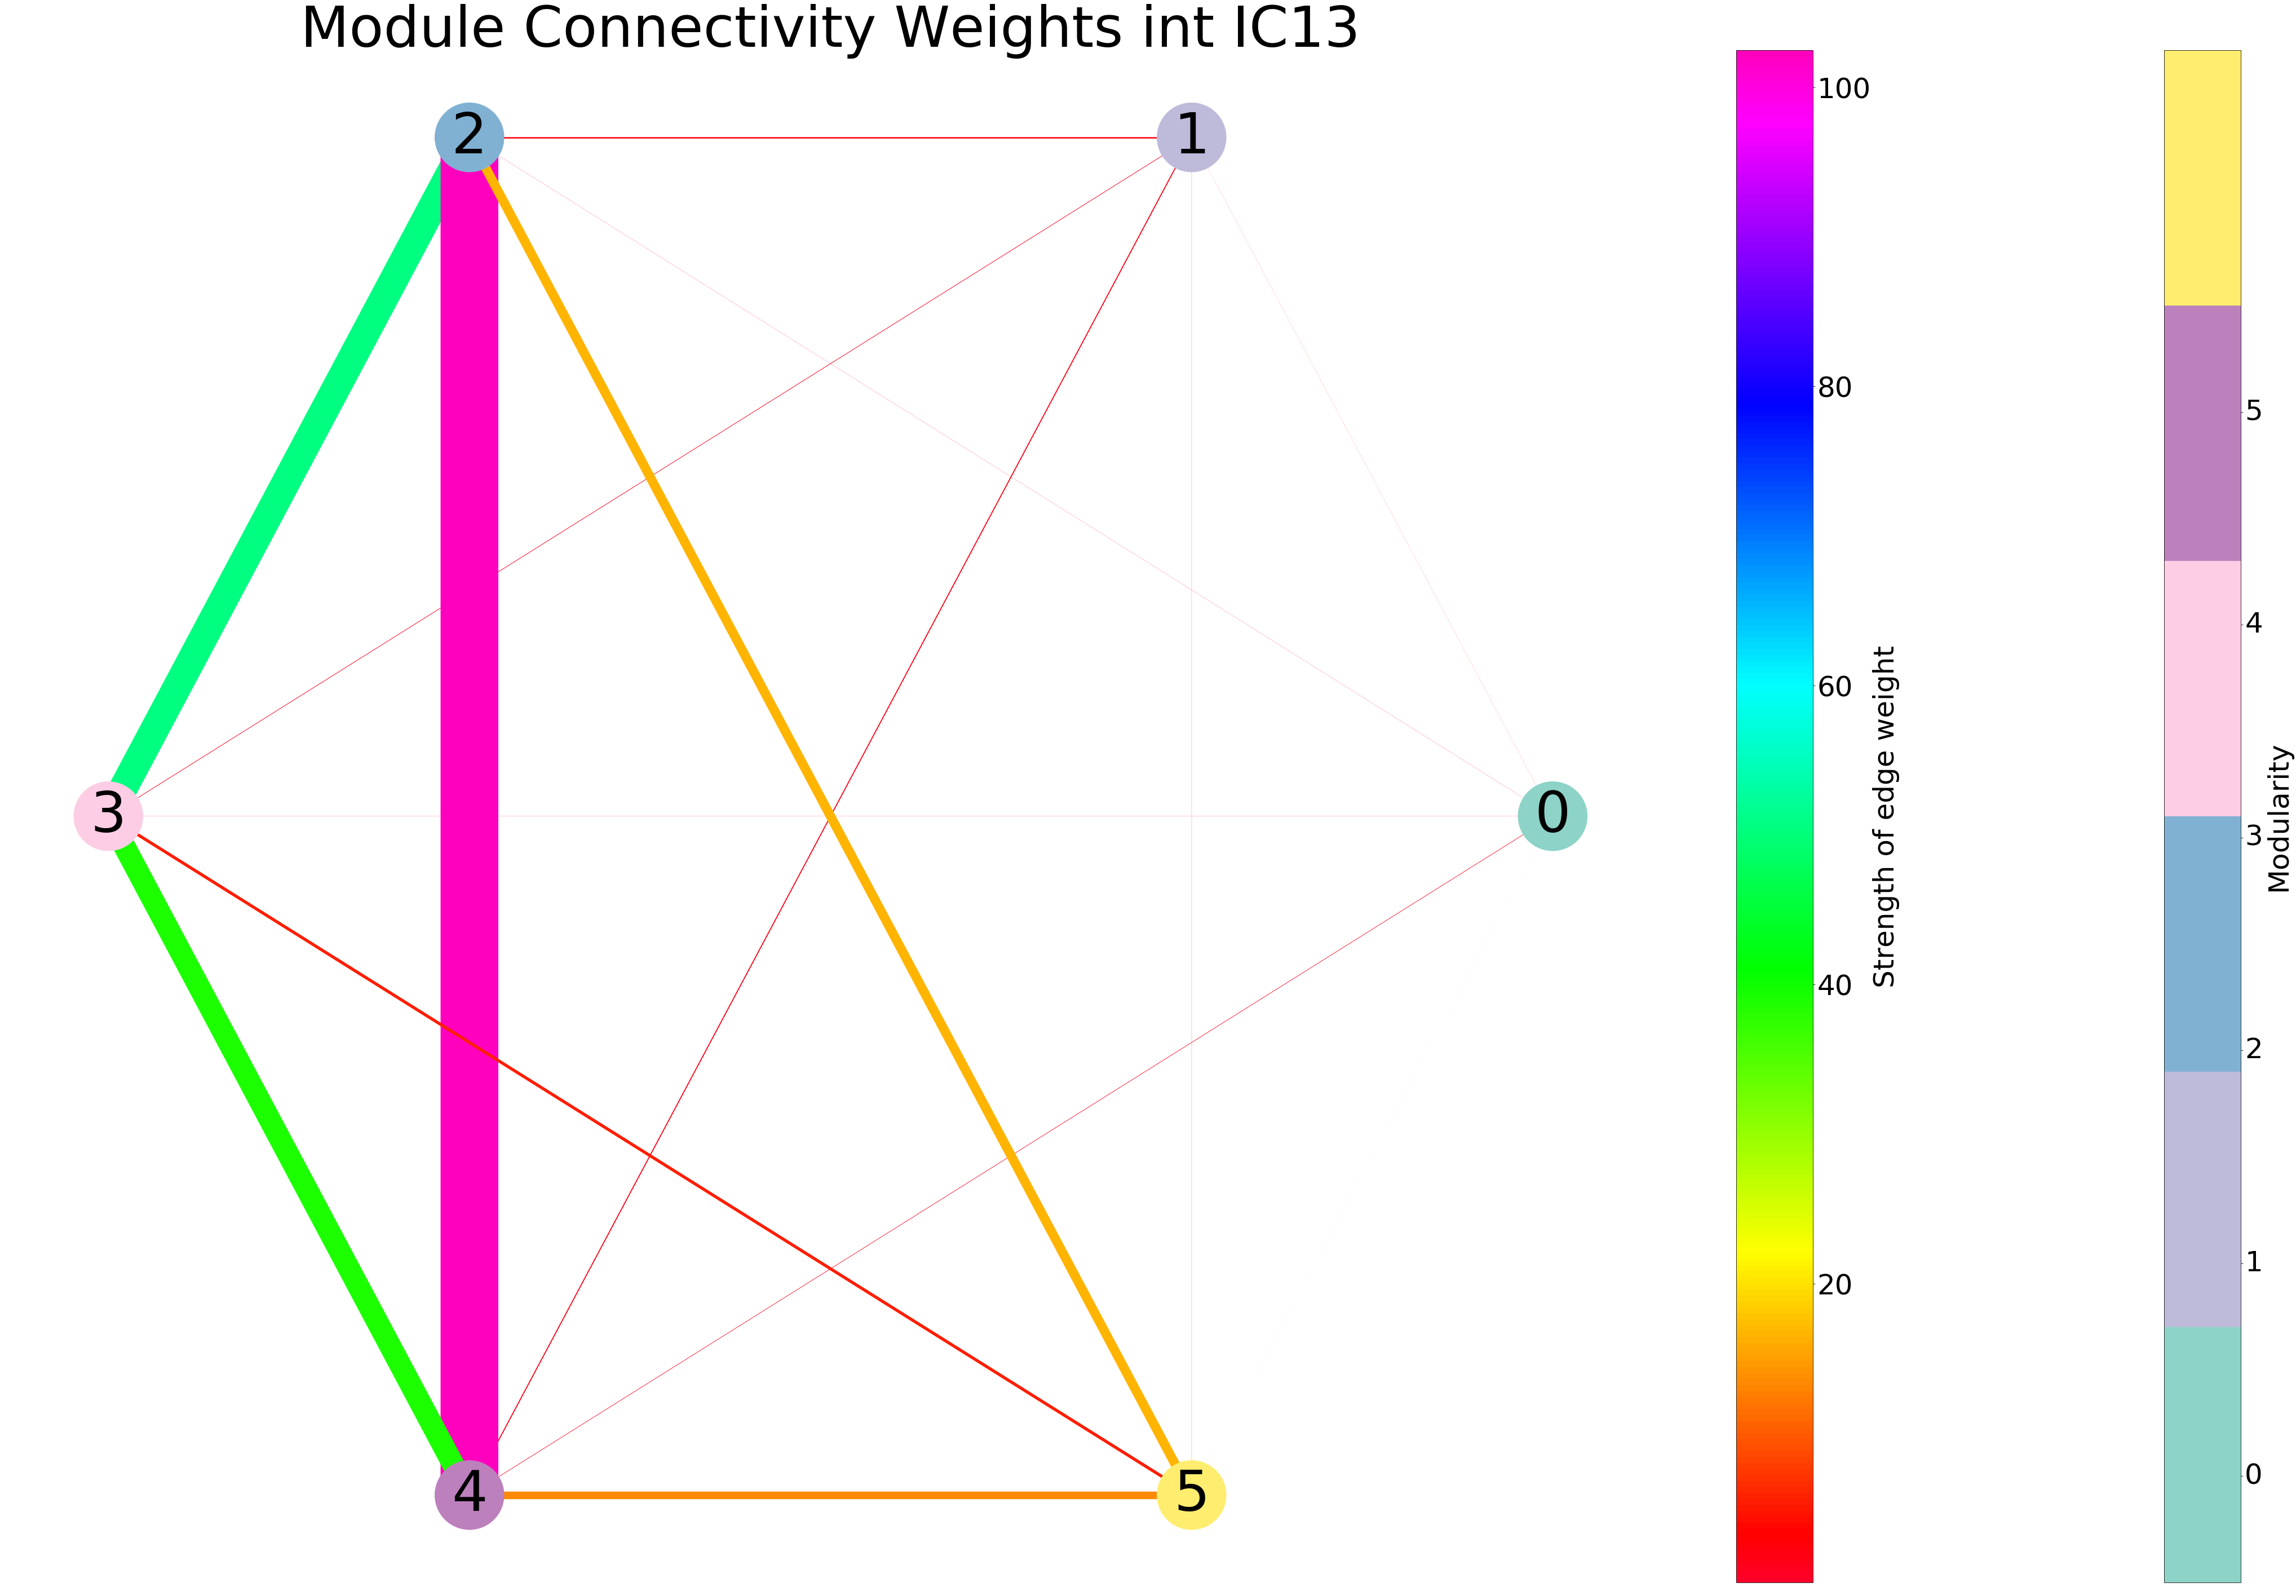

In [117]:
community_graphs= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}
for t, item in graphs.items():
#     for group, v in item.items():
    for IC, data in item['int'].items():
        comm_graph = community.induced_graph(data['modules']['partition'], 
                                        data['modules']['graph'])
        community_graphs[t][group][IC]=comm_graph
        print(IC)
        module_fig(comm_graph, group, IC)

# Summary
The module graphs show that the connectivity of the modules containing the interaction term are rather weak. Especially in IC3 and IC12 (module 2), they are only weakly related to the other modules. In ICs 4 and 13 we see a more robust response. This suggest to me that 4 and 12 are driving their respective connections with 3 and 12. 

In [ ]:
nega_community_graphs= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

for t, item in nega_graphs.items():
    for group, v in item.items():
        for IC, data in v.items():
            comm_graph = community.induced_graph(data['modules']['partition'], 
                                            data['modules']['graph'])
            nega_community_graphs[t][group][IC]=comm_graph
            print(IC)
#             module_fig(comm_graph, group, IC)

In [ ]:
community_graphs['late']['int']['IC6'].nodes(data=True)

# Summary
There are far fewer nodes and modules in the negative correlation graphs. Interestingly, in the IC2 and IC3 the module with the interaction term is different (0 vs. 2). It appears IC2 is driving the inverse relationship. 

In [ ]:
module_fig(community_graphs['early']['int']['IC6'], 'int', 'IC6')

In [ ]:
# graphs['late']['BMI']['IC1']['PC'][0]

In [72]:
dictMeanMod={'late':{'IC2':{'mean':{},'SD':{},'raw':{},'z':{}},'IC3':{'mean':{},'SD':{},'raw':{},'z':{}},'IC6':{'mean':{},'SD':{},'raw':{},'z':{}},'IC12':{'mean':{},'SD':{},'raw':{},'z':{}},'IC13':{'mean':{},'SD':{},'raw':{},'z':{}}}, 
             'early':{'IC2':{'mean':{},'SD':{},'raw':{},'z':{}},'IC3':{'mean':{},'SD':{},'raw':{},'z':{}},'IC6':{'mean':{},'SD':{},'raw':{},'z':{}},'IC12':{'mean':{},'SD':{},'raw':{},'z':{}},'IC13':{'mean':{},'SD':{},'raw':{},'z':{}}}}
for t, item in graphs.items():
    for IC, value in item['int'].items():
        G=value['graphs']
        G.nodes(data=True)
        for M in list(set(value['modules']['values'])):
            print(M)
            interest = [x for x,y in G.nodes(data=True) if y['modules']==M]
            X=nx.subgraph(G, interest)
            dictInt=dict(X.degree)
            keys=list(dictInt.keys())
            mu=np.mean(list(dictInt.values()))
            sd=np.std(list(dictInt.values()))
            z=np.subtract(list(dictInt.values()),mu)
            if sd == 0:
                SD=[1]*len(z)
                Z=np.divide(z,SD)
                zD = dict(zip(keys, Z))
                dictMeanMod[t][IC]['z'][M]=zD
                nx.set_node_attributes(G, zD, 'zD')
            else:
                SD=[sd]*len(z)
                Z=np.divide(z,SD)
                zD = dict(zip(keys, Z))
                dictMeanMod[t][IC]['z'][M]=zD
                nx.set_node_attributes(G, zD, 'zD')
            dictMeanMod[t][IC]['mean'][M]=mu
            dictMeanMod[t][IC]['SD'][M]=sd
            dictMeanMod[t][IC]['raw'][M]=dictInt
            
            
            

0
1
2
3
4
5
6
7
8
0
1
2
3
0
1
2
3
4
5
6
7
8
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
5
6
7
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
0
1
2
3
4
5


In [74]:
graphs['late']['int']['IC2']['graphs'].nodes(data=True)

NodeDataView({'BMI': {'modules': 0, 'centrality': 0.0003968253968253968, 'clustering': 0.9, 'zDegree': 1.0789062758055146, 'PC': 0.0, 'zD': 0.7071067811865469}, 'AoM': {'modules': 1, 'centrality': 0.007671957671957673, 'clustering': 0.9191176470588235, 'zDegree': 0.0, 'PC': 0.9889196675900277, 'zD': 0.0}, 'int': {'modules': 0, 'centrality': 0.014285714285714292, 'clustering': 0.6666666666666666, 'zDegree': 1.1215139377290044, 'PC': 0.234375, 'zD': 0.7071067811865469}, 'race': {'modules': 0, 'centrality': 0.0904761904761905, 'clustering': 0.4888888888888889, 'zDegree': -1.3755871764536964, 'PC': 0.75, 'zD': -1.4142135623730956}, 'age': {'modules': 0, 'centrality': 0.049999999999999996, 'clustering': 0.42857142857142855, 'zDegree': -1.0558507706912188, 'PC': 0.5555555555555556, 'zD': -1.4142135623730956}, 'motion': {'modules': 0, 'centrality': 0.0003968253968253968, 'clustering': 0.9, 'zDegree': 0.6372474071166857, 'PC': 0.0, 'zD': 0.7071067811865469}, 48: {'modules': 2, 'centrality': 5.

In [83]:
exports= {'late':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}
           },'early':
           {'BMI':
            {'IC1':{},'IC3':{},'IC4':{},'IC5':{},'IC6':{},'IC7':{},'IC8':{},'IC9':{},'IC10':{},'IC11':{},'IC12':{},'IC13':{},'IC14':{},'IC15':{}},
            'AoM':
            {'IC12':{},'IC15':{}},
            'int':
            {'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}}

nodelist=[]
edgelist=[]
for t, item in graphs.items():
    print(t)
    for group, value in item.items():
        print(group)
        if group == 'int':
            for IC, v in value.items():
                print(IC)
                e,w = zip(*nx.get_edge_attributes(v['graphs'], 'weight').items())
                edf = pd.DataFrame(list(e),columns=['x','y'])
                edf['edge_weight']=list(w)
                edf['group']=group
                edf['early_late']=t
                edf['IC']=IC
                n1,cc = zip(*nx.get_node_attributes(v['graphs'], 'clustering').items())
                df=pd.DataFrame(list(cc),columns=['cc'])
                n2,btw = zip(*nx.get_node_attributes(v['graphs'], 'centrality').items())
                df['btw']=list(btw)
                n3,mod = zip(*nx.get_node_attributes(v['graphs'], 'modules').items())
                df['module']=list(mod)
                df['group']=group
                df['early_late']=t
                df['IC']=IC
                df['node']=n2
                n4,PC = zip(*nx.get_node_attributes(v['graphs'], 'PC').items())
                df['PC']=list(PC)
                n5,zD = zip(*nx.get_node_attributes(v['graphs'], 'zD').items())
                df['zDegree']=list(zD)
                exports[t][group][IC]=df
                nodelist.append(df)
                edgelist.append(edf)
        
            

node_df=pd.concat(nodelist)
pd.DataFrame.to_csv(node_df,'/Users/gracer/Google Drive/HCP_graph/1200/datasets/early_late_nodes_new_z.csv',sep=',')
edge_df=pd.concat(edgelist)
edge_df = edge_df[edge_df['x'] != edge_df['y']]
pd.DataFrame.to_csv(edge_df,'/Users/gracer/Google Drive/HCP_graph/1200/datasets/early_late_edges_new_z.csv',sep=',')


late
BMI
AoM
int
IC2
IC3
IC6
IC12
IC13
early
BMI
AoM
int
IC2
IC3
IC6
IC12
IC13


In [ ]:
test=node_df.loc[(node_df['group'] == 'int') &( node_df['early_late'] == 'late') & ( node_df['module'] == 0) & ( node_df['IC'] == 'IC2')]['node']
test0=node_df.loc[(node_df['group'] == 'int') &( node_df['early_late'] == 'early') & ( node_df['module'] == 0) & ( node_df['IC'] == 'IC2')]['node']


In [ ]:
ALL_DATA={
'dfs':dfs,
'zscores_thr':zscores_thr,
'graphs':graphs,
'nega_graphs':nega_graphs,
'subgraphs':subgraphs,
'community_graphs':community_graphs,
'exports':exports
         }

In [ ]:
pickle.dump(ALL_DATA, open('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalApril6.pkl', 'wb'), protocol=4)

In [ ]:
ALL_DATA=onetoughjar('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalel.pkl')

In [ ]:
dfs=ALL_DATA['dfs']
graphs=ALL_DATA['graphs']
zscores_thr=ALL_DATA['zscores_thr']
nega_graphs=ALL_DATA['nega_graphs']
dfs=ALL_DATA['dfs']
subgraphs=ALL_DATA['subgraphs']
community_graphs=ALL_DATA['community_graphs']

In [ ]:
graphs['late']['BMI']['IC1']['modules']['graph']

# Checking signficant differences between groups

In [ ]:
def edgy(H):
    print('start edges')
    e,w = zip(*nx.get_edge_attributes(H, 'weight').items())
    edf = pd.DataFrame(list(e),columns=['x','y'])
    edf['edge_weight']=list(w)
    edf = edf[edf['x'] != edf['y']]
    return(edf)

In [ ]:
def find_mod(G,mod):
    print(mod)
    area=[a for a, m in nx.get_node_attributes(G, 'modules').items() if m == mod]
    H = G.subgraph(area)
    edf=edgy(H)
    print(edf.sort_values(by=['edge_weight']))
    for x in area:
        y=labels.iloc[x][0]
        print('Area %s in module %s is %s'%(x,mod,y))
    return(edf)
    
    

In [ ]:
def hood(x,G,node,graph):
    a=list(x['x'])+list(nx.all_neighbors(G, node))
    nodes=list(set(a))
    outer= G.subgraph(nodes)
    edf=edgy(outer)
    edf = edf[edf['x'] == node]
    print(edf.sort_values(by=['edge_weight']))
    if graph == 'yes':
        grace_graph(outer, 'Connections')
    return(edf)

In [ ]:
G=graphs['late']['int']['IC6']['graphs']
x=find_mod(G, 8)

In [ ]:
def edgy(H):
    print('start edges')
    e,w = zip(*nx.get_edge_attributes(H, 'weight').items())
    edf = pd.DataFrame(list(e),columns=['x','y'])
    edf['edge_weight']=list(w)
    edf = edf[edf['x'] != edf['y']]
    return(edf)

In [ ]:
def find_mod(G,mod):
    print(mod)
    area={}
    indx=[a for a, m in nx.get_node_attributes(G, 'modules').items() if m == mod]
    for b, n in nx.get_node_attributes(G, 'area').items():
        area[b]=n
    H = G.subgraph(indx)
    edf=edgy(H)
    print(edf.sort_values(by=['edge_weight']))
    for x in indx:
        try:
            y=labels.loc[x][0]
            print('Area %s in module %s is %s'%(x,mod,y))
        except:
            y=area[x]
            print('Area %s in module %s is %s'%(x,mod,y))
    return(edf)
    
    

In [ ]:
def hood(x,G,node,graph):
    a=list(x['x'])+list(nx.all_neighbors(G, node))
    nodes=list(set(a))
    outer= G.subgraph(nodes)
    edf=edgy(outer)
    edf = edf[edf['x'] == node]
    print(edf.sort_values(by=['edge_weight']))
    if graph == 'yes':
        grace_graph(outer, 'Connections','no')
    return(edf)

In [ ]:
def hot(cor, name):
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(21, 15))
        ax = sns.heatmap(cor,annot=False, vmin=-1, vmax=1,square=True, cmap='gnuplot2',fmt='f')
        ax.set_title(name)



In [ ]:
G=graphs['late']['int']['IC6']['graphs']
x=find_mod(G, 8)

In [ ]:
t=hood(x,G,345,'yes')

In [ ]:
for item in t['y']:
    print(item)
    print(G.nodes(data=True)[item])
    mod=G.nodes(data=True)[item]['modules']
    find_mod(G, mod)

In [ ]:
grace_graph(G.subgraph(a), 'Int_test')

# LAST IDEA

In [ ]:
ALL_DATA=onetoughjar('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalel.pkl')

Idea, concatonate the cconnected graphs to see how they interact with each other. Port into R for rmcorr, here for viz

In [ ]:
df = pd.DataFrame()
datas={'late':
  {'int': {'IC_2_3':df, 'IC_3_6':df, 'IC_12_13':df}},
 'early': {
  'int': {'IC_2_3':df, 'IC_3_6':df, 'IC_12_13':df}}}
A={'late':{'int':{
    'IC_2_3':{}, 'IC_3_6':{}, 'IC_12_13':{}}},
 'early': {'int':
           {'IC_2_3':{}, 'IC_3_6':{}, 'IC_12_13':{}}}}
l=['BMI','int','AoM','motion','age','race']
for t, item in datas.items():
    for IC, df in item['int'].items():
        ses=IC.split('_')
        for x in ses[1:3]:
            col_names=list(zscores_thr[t]['int']['IC%s'%(x)].columns[7:])
            L={}
            for i in col_names:
                try:
                    sp=i.split('_')
                    L[i]='%s_%s'%(sp[0],sp[1])
                except:
                    L[i]='%s_%s'%(str(i),x)
            zscores_thr[t]['int']['IC%s'%(x)] = zscores_thr[t]['int']['IC%s'%(x)].rename(L, axis='columns')
            for indx, val in label_dict.items():
                key='%s_%s'%(indx,x)
                value='%s_%s'%(val['area'],x)
                A[t]['int'][IC][key]=value
        dataf=zscores_thr[t]['int']['IC%s'%(ses[1])].merge(zscores_thr[t]['int']['IC%s'%(ses[2])], left_on=l, right_on=l)
        pd.DataFrame.to_csv(dataf,'/Users/gracer/Google Drive/HCP_graph/1200/datasets/%s_%s.csv'%(t,IC),sep=',')
        datas[t]['int'][IC]=mu_make_graphs(IC, dataf.corr(), 'positive')
        nx.set_node_attributes(datas[t]['int'][IC]['graphs'], t,'group')
        hot(dataf.corr(),'%s %s'%(t,IC))


In [ ]:
fix=['BMI','AoM','int','race','age','motion']
for t, f in A.items():
    for x,y in f['int'].items():
        for item in fix:
            y[item]=item

In [ ]:
for t, first in datas.items():
    for IC, value in first['int'].items():
        nx.set_node_attributes(value['graphs'],A[t]['int'][IC],'area')

In [ ]:
G=datas['early']['int']['IC_3_6']['graphs']
R=find_mod(G,5)

In [ ]:
x=hood(R,G,'int','yes')

In [ ]:
t=hood(x,G,345,'yes')

In [ ]:
for item in t['y']:
    print(item)
    print(G.nodes(data=True)[item])
    mod=G.nodes(data=True)[item]['modules']
    find_mod(G, mod)

In [ ]:
grace_graph(G.subgraph(a), 'Int_test')

In [ ]:
testdata=onetoughjar('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalhl.pkl')

In [ ]:
testdata.keys()

In [ ]:
testdata['community_graphs']['early']['AoM']['IC12']

# LAST IDEA

Idea, concatonate the cconnected graphs to see how they interact with each other. Port into R for rmcorr, here for viz

In [ ]:
df = pd.DataFrame()
datas={'late':
  {'int': {'IC_2_3':df, 'IC_3_6':df, 'IC_12_13':df}},
 'early': {
  'int': {'IC_2_3':df, 'IC_3_6':df, 'IC_12_13':df}}}

for t, item in datas.items():
    print(t)
    for IC, df in item['int'].items():
        print(IC)
        ses=IC.split('_')
        print(ses)
        for x in ses[1:2]:
            print(x)
            dfs[t]['int']['IC%s'%(x)]['IC']='IC%s'%(x)
        dataf=pd.concat([dfs[t]['int']['IC%s'%(ses[1])],dfs[t]['int']['IC%s'%(ses[2])]])
        pd.DataFrame.to_csv(dataf,'/Users/gracer/Google Drive/HCP_graph/1200/datasets/%s.csv'%(IC),sep=',')
        datas[t]['int'][IC] = dataf.append(df, ignore_index = False)

# Checking z degree


In [ ]:
def module_degree_zscore(W, ci, flag=0):
    '''
    The within-module degree z-score is a within-module version of degree
    centrality.
    Parameters
    ----------
    W : NxN np.narray
        binary/weighted directed/undirected connection matrix
    ci : Nx1 np.array_like
        community affiliation vector
    flag : int
        Graph type. 0: undirected graph (default)
                    1: directed graph in degree
                    2: directed graph out degree
                    3: directed graph in and out degree
    Returns
    -------
    Z : Nx1 np.ndarray
        within-module degree Z-score
    '''
    _, ci = np.unique(ci, return_inverse=True)
    ci = ci + 1

    if flag == 2:
        W = W.copy()
        W = W.T
    elif flag == 3:
        W = W.copy()
        W = W + W.T

    n = len(W)
    print("this is n %i"%n)
    Z = np.zeros((n,1))  # number of vertices
    for i in range(1, int(np.max(ci) + 1)):
        Koi = np.sum(W[np.ix_(ci == i, ci == i)], axis=1)
        Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)

    Z[np.where(np.isnan(Z))] = 0
    return Z

where κni is the number of edges connecting the  i th node to other  nodes in the  n th module, κn is the average of κni over all nodes in  the module  n , and   σκn   is the standard deviation of the intra-modular  degrees in the  n th module.

In [66]:
graphs['late']['int']['IC2']['graphs'].nodes(data=True)

NodeDataView({'BMI': {'modules': 0, 'centrality': 0.0003968253968253968, 'clustering': 0.9, 'zDegree': 1.0789062758055146, 'PC': 0.0, 'zD': 0.7071067811865469}, 'AoM': {'modules': 1, 'centrality': 0.007671957671957673, 'clustering': 0.9191176470588235, 'zDegree': 0.0, 'PC': 0.9889196675900277, 'zD': 0.0}, 'int': {'modules': 0, 'centrality': 0.014285714285714292, 'clustering': 0.6666666666666666, 'zDegree': 1.1215139377290044, 'PC': 0.234375, 'zD': 0.7071067811865469}, 'race': {'modules': 0, 'centrality': 0.0904761904761905, 'clustering': 0.4888888888888889, 'zDegree': -1.3755871764536964, 'PC': 0.75, 'zD': -1.4142135623730956}, 'age': {'modules': 0, 'centrality': 0.049999999999999996, 'clustering': 0.42857142857142855, 'zDegree': -1.0558507706912188, 'PC': 0.5555555555555556, 'zD': -1.4142135623730956}, 'motion': {'modules': 0, 'centrality': 0.0003968253968253968, 'clustering': 0.9, 'zDegree': 0.6372474071166857, 'PC': 0.0, 'zD': 0.7071067811865469}, 48: {'modules': 2, 'centrality': 5.

In [60]:
dictDF={'late':{'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}, 
             'early':{'IC2':{},'IC3':{},'IC6':{},'IC12':{},'IC13':{}}}

for t, item in dictMeanMod.items():
    for IC, value in item.items():
        print(value['z'])
        dictDF[t][IC]=pd.DataFrame.from_dict(value['z'])

{0: {'race': -1.4142135623730956, 162: 0.7071067811865469, 'age': -1.4142135623730956, 'int': 0.7071067811865469, 'motion': 0.7071067811865469, 'BMI': 0.7071067811865469}, 1: {'AoM': 0.0}, 2: {48: 0.0, 264: 0.0, 228: 0.0}, 3: {231: 0.0, 232: 0.0, 233: 0.0, 263: 0.0, 359: 0.0, 51: 0.0, 53: 0.0}, 4: {265: 0.0, 266: 0.0, 268: 0.0, 269: 0.0, 88: 0.0}, 5: {168: 0.0, 270: 0.0, 150: 0.0, 90: 0.0, 285: 0.0}, 6: {328: 0.0, 169: 0.0, 330: 0.0, 331: 0.0, 375: 0.0, 347: 0.0, 348: 0.0, 349: 0.0}, 7: {267: 0.0}, 8: {275: 0.0}}
{0: {'int': 0.0, 'age': 0.0, 'motion': 0.0, 'BMI': 0.0}, 1: {'race': 0.0, 'AoM': 0.0}, 2: {199: 0.0, 203: 0.0, 204: 0.0, 19: 0.0, 23: 0.0, 24: 0.0}, 3: {40: 0.0, 219: 0.0, 220: 0.0, 39: 0.0}}
{0: {224: 0.6324555320336755, 'race': -1.5811388300841898, 163: 0.6324555320336755, 'age': -1.5811388300841898, 'int': 0.6324555320336755, 'motion': 0.6324555320336755, 'BMI': 0.6324555320336755}, 1: {'AoM': 0.0}, 2: {96: 0.0, 165: 0.0, 166: 0.0, 43: 0.0, 155: 0.0, 123: 0.0}, 3: {312: 0.0

In [61]:
dictDF['late']['IC2']

0    1    2    3    4    5    6    7    8
race   -1.414214  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
162     0.707107  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
age    -1.414214  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
int     0.707107  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
motion  0.707107  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
BMI     0.707107  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
AoM          NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
48           NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN
264          NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN
228          NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN
231          NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
232          NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
233          NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
263          NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
359          NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
51           NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
53           NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN
265          NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN
266          NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN
268          NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN
269          NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN
88           NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN
168          NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN
270          NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN
150          NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN
90           NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN
285          NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN
328          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
169          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
330          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
331          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
375          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
347          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
348          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
349          NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN
267          NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN
275          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0

In [ ]:
for t, item in graphs.items():
    for group, v in item.items():
        print(group)
        for IC, value in v.items():
            G=value['graphs']
            G.nodes(data=True)
            dictAlpha=dict(G.degree)
            dictGamma={}
            for M in list(set(value['modules']['values'])):
                interest = [x for x,y in G.nodes(data=True) if y['modules']==M]
                X=nx.subgraph(G, interest)
                dictOmega=dict(X.degree)
                for key, value in dictOmega.items():
                    test=1-np.square(value/dictAlpha[key])
                    dictGamma[key] = test
                    print("this is the module %s"%M)
            nx.set_node_attributes(G, dictGamma, 'PC')

In [16]:
ALL_DATA=onetoughjar('/Users/gracer/Google Drive/HCP_graph/1200/datasets/finalApril6.pkl')

In [17]:
dfs=ALL_DATA['dfs']
graphs=ALL_DATA['graphs']
zscores_thr=ALL_DATA['zscores_thr']
nega_graphs=ALL_DATA['nega_graphs']
dfs=ALL_DATA['dfs']
subgraphs=ALL_DATA['subgraphs']
community_graphs=ALL_DATA['community_graphs']